# Preparing

In [1]:
import logging
import json
import gc
import os
import pickle
import joblib
import re
import math
import warnings
import string
from datetime import timedelta, datetime
from itertools import combinations, groupby

import numpy as np
import pandas as pd
import boto3
from io import BytesIO
from pandas.errors import PerformanceWarning

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

from feature_engine.encoding.rare_label import RareLabelEncoder
from feature_engine.encoding import WoEEncoder
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropCorrelatedFeatures,
    SelectByTargetMeanPerformance
)

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    accuracy_score,
    auc,
    log_loss,
    make_scorer,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    train_test_split,
)

from optbinning import OptimalBinning

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [2]:
# import from transformers

from transformers.helpers import (
    add_ww_mm_date, 
    df_filter_by_dts,
)

from transformers.constants import (
    DT_LABEL,
    TS_COL,
    TARGET,
    MISSING,
    NAN,
    OTHER,
    CAT,
    NUM,
    BIN,
    WOE,
    SEP,
    GROUPS,
    DT_START,
    DT_END,
)

from transformers.logger import logger

from transformers.preparing import (
    read_data,
    compute_salary_median,
    parse_dates,
    calculate_age_experience,
    rename_features
)

In [3]:
from transformers.simple_features_transformer import SimpleFeaturesTransformer

from transformers.py_classes import (
    BinningCategoriesTransformer_collection,
    BinningNumericalTransformer_collection,
    WoeEncoderTransformer_collection,
    FeatureEliminationTransformer,
    CustomRareCategoriesTransformer,
    CustomLogisticRegressionClassifier,
)

# Read and prepare data

## Read full parsed DataFrame

In [4]:
# --- Synthetic data generation (public demo) ---
# This replaces any proprietary data loading.
# The dataset mimics a collections / payments use case with:
# - customer attributes
# - collection activity signals
# - credit bureau style aggregates
# - risk / arrears signals
#
# Targets:
# - target: payment event (0/1)
# - amount_of_payment: payment amount (0 if not paid)

import numpy as np
import pandas as pd

np.random.seed(42)

N = 12000

# Helper generators
def choice(vals, p=None):
    return np.random.choice(vals, size=N, p=p)

def lognorm(mu, sigma):
    return np.random.lognormal(mean=mu, sigma=sigma, size=N)

def clipped_normal(mu, sigma, lo, hi):
    return np.random.normal(mu, sigma, size=N).clip(lo, hi)

df_sample = pd.DataFrame({
    "loan_id": np.arange(N),
    "snap_date": pd.to_datetime("2025-01-01") + pd.to_timedelta(np.random.randint(0, 150, size=N), unit="D"),

    # categorical
    "loan_name": choice(["Product_A", "Product_B", "Product_C"], p=[0.45, 0.35, 0.20]),
    "customer.addressLGA": choice(["LGA_1", "LGA_2", "LGA_3", "LGA_4", "LGA_5"]),
    "customer.employment.employerLGA": choice(["LGA_1", "LGA_2", "LGA_3", "LGA_4", "LGA_5"]),
    "customer.employment.businessSector": choice(["Retail", "Services", "Manufacturing", "Public", "Other"]),
    "application.existingCustomer": choice(["Y", "N"], p=[0.55, 0.45]),
    "application.loanType": choice(["Type_1", "Type_2", "Type_3"]),
    "application.requestedLoanAmount": lognorm(10.2, 0.45),
    "application.lastLoanStatus": choice(["Paid", "Default", "Active", "Unknown"], p=[0.45, 0.10, 0.30, 0.15]),
    "application.employmentSector": choice(["Retail", "Services", "Manufacturing", "Public", "Other"]),
    "application.employmentStatus": choice(["Employed", "Self-Employed", "Unemployed"], p=[0.68, 0.18, 0.14]),
    "application.maritalStatus": choice(["Single", "Married", "Divorced", "Other"], p=[0.48, 0.44, 0.06, 0.02]),
    "bvn.stateOfOrigin": choice(["State_1", "State_2", "State_3", "State_4", "State_5"]),
    "cb_avg.highestRepaymentStatus": choice(["Good", "Neutral", "Bad", "Unknown"], p=[0.65, 0.20, 0.08, 0.07]),
    "gender": choice(["M", "F"], p=[0.55, 0.45]),
    "labeling": choice(["segment_A", "segment_B", "segment_C"], p=[0.40, 0.35, 0.25]),

    # numeric (a subset of the feature list; missing ones will be created below)
    "loan_num": np.random.randint(1, 8, size=N),
    "num_collection": np.random.poisson(1.5, size=N),
    "non_null_default_reason_count": np.random.poisson(0.4, size=N),
    "keptpromise_ratio": np.random.beta(2, 6, size=N),
    "ptp_amount_paid_ratio": np.random.beta(2, 5, size=N),
    "total_payment": lognorm(9.2, 0.7),
    "total_number_of_payments": np.random.poisson(2.2, size=N),
    "total_contact_flag": np.random.binomial(1, 0.75, size=N),
    "total_contact_flag_coll": np.random.binomial(1, 0.65, size=N),
    "days_since_last_payment": clipped_normal(18, 14, 0, 180),
    "promised_amount": lognorm(9.0, 0.8),

    "daily_arrearsprincipal": lognorm(8.6, 0.9),
    "daily_arrearsinterest": lognorm(7.8, 1.0),
    "daily_penaltydue": lognorm(7.2, 1.1),

    "application.renMaxDPD": clipped_normal(22, 18, 0, 180),
    "salary_median": lognorm(10.1, 0.5),

    "cb_avg.outstandingloan": lognorm(10.3, 0.55),
    "cb_avg.totalMonthlyInstallments": lognorm(9.4, 0.6),
    "cb_avg.currentDPD": clipped_normal(10, 12, 0, 180),
    "cb_avg.maxDPD": clipped_normal(24, 18, 0, 180),
    "age": clipped_normal(34, 9, 18, 70),
    "experience": clipped_normal(6, 6, 0, 35),

    "cb_avg.noOfLoans": np.random.poisson(3.0, size=N),
    "cb_avg.noOfNonPerformingLoans": np.random.poisson(0.3, size=N),
    "cb_avg.noOfBadAccounts": np.random.poisson(0.25, size=N),
})

# Ensure all numeric features from num_features_dct exist (fill missing with plausible synthetic values)
for col, default in num_features_dct.items():
    if col not in df_sample.columns:
        # Create synthetic numeric features with mild randomness around default/scale
        df_sample[col] = np.where(
            np.random.rand(N) < 0.05,
            np.nan,
            default + np.random.normal(0, 1.0, size=N)
        )

# Latent propensity -> payment probability
z = (
    0.9 * (df_sample["application.employmentStatus"].eq("Employed").astype(int))
    + 0.5 * (df_sample["application.existingCustomer"].eq("Y").astype(int))
    + 0.25 * np.log1p(df_sample["total_number_of_payments"].clip(0, 20))
    - 0.015 * df_sample["days_since_last_payment"].clip(0, 180)
    - 0.12 * (df_sample["cb_avg.maxDPD"] > 60).astype(int)
    - 0.10 * (df_sample["application.renMaxDPD"] > 60).astype(int)
    + 0.20 * df_sample["keptpromise_ratio"].fillna(0)
    + np.random.normal(0, 0.45, size=N)
)

p_pay = 1 / (1 + np.exp(-z))
df_sample[TARGET] = (np.random.rand(N) < p_pay).astype(int)

# Amount for payers only (two-stage)
base_amount = (
    0.35 * df_sample["promised_amount"].fillna(0)
    + 0.20 * df_sample["total_payment"].fillna(0)
    + 0.10 * df_sample["salary_median"].fillna(0)
    - 2500 * (df_sample["cb_avg.maxDPD"] > 60).astype(int)
    + lognorm(8.1, 0.45)
)

df_sample["amount_of_payment"] = np.where(df_sample[TARGET] == 1, base_amount, 0.0).clip(0, None)

df_sample.head()


In [5]:
# Data is generated above (synthetic public demo)


In [6]:
df_sample = df_sample.drop(columns=[
                        'Unnamed: 0.1', 
                        'Unnamed: 0', 
                        "application.bvnage",
                        "segment_loan_tenor",
                        "segment_loan_amount"
    ])

df_sample.rename(columns={"target_flag": "target"}, inplace=True)

## Time features

In [7]:
# Convert necessary columns to datetime
date_columns = ["snap_date", "loan_date", "loan_due_date"]
df_sample[date_columns] = df_sample[date_columns].apply(pd.to_datetime)

# Drop all date columns
df_sample = df_sample.drop(columns=["loan_date", "loan_due_date"])

## Split by buckets and product

In [8]:
df_sample["overdue_bucket"].value_counts(dropna = False)

90-180     66211
5-30       64625
30-60      59516
60-90      47225
180-360    15564
Name: overdue_bucket, dtype: int64

In [9]:
categories = {
    "PL_ZEUS": [
        "INSTANT  LOAN",
        "Personal Loan - New",
        "Personal Loan - TopUp",
        "Zeus",
        "Personal Loan - Renewal",
        "Personal Loan - Buyback",
        "Personal Loan - Buyback returning"
    ],
    "TWO_WEEK": [
        "2 Week Instant Loan",
        "2 Week Zeus"
    ],
    "SEL_BETA": [
        "Self Employed - Weekly New",
        "Self Employed Renewal Weekly",
        "Self Employed New - Monthly",
        "Self Employed Loan - Weekly TopUp",
        "Self Employed Renewal Monthly",
        "Self Employed Loan - Monthly TopUp",
        "Beta Loan – NTB",
        "Beta Loan – Renewal",
        "Personal Loan – Beta NTB"
    ],
}

In [10]:
def clean_bucket_name(bucket):
     return str(bucket).replace('-', '_').replace('+', 'plus')

# Iterate through categories
for category_name, loan_list in categories.items():
    for bucket in df_sample["overdue_bucket"].unique():
        # Filter by loan name and overdue bucket
        df_filtered = df_sample[(df_sample["loan_name"].isin(loan_list)) & (df_sample["overdue_bucket"] == bucket)]
        
        # Create a dynamic name for DataFrame
        df_name = f"df_{category_name}_{clean_bucket_name(bucket)}"
        
        # Store in global space
        globals()[df_name] = df_filtered

# Define your custom merge mapping
merge_map = {
    "df_PL_ZEUS_5_30": ["df_PL_ZEUS_5_30"], 
    "df_PL_ZEUS_30_60": ["df_PL_ZEUS_30_60"], 
    "df_PL_ZEUS_60_360": ["df_PL_ZEUS_60_90", "df_PL_ZEUS_90_180", "df_PL_ZEUS_180_360"],
    
    "df_TWO_WEEK_5_30": ["df_TWO_WEEK_5_30"], 
    "df_TWO_WEEK_30_360": ["df_TWO_WEEK_30_60", 
                           "df_TWO_WEEK_60_90", 
                           "df_TWO_WEEK_90_180", 
                           "df_TWO_WEEK_180_360"],
    
    "df_SEL_BETA_5_30": ["df_SEL_BETA_5_30"],
    "df_SEL_BETA_30_60" : ["df_SEL_BETA_30_60"],
    "df_SEL_BETA_60_360": ["df_SEL_BETA_60_90", "df_SEL_BETA_90_180", "df_SEL_BETA_180_360"]
}

# Combine and summarize
table_results = []

for new_df_name, source_names in merge_map.items():
    combined_dfs = [globals().get(name) for name in source_names if globals().get(name) is not None]
    
    if not combined_dfs:
        print(f"Warning: No valid DataFrames found for {new_df_name}. Skipping.")
        continue

    combined_df = pd.concat(combined_dfs, ignore_index=True)
    globals()[new_df_name] = combined_df

    shape = combined_df.shape
    target_counts = combined_df["target"].value_counts().to_dict()

    table_results.append([
        new_df_name, shape[0], shape[1],
        target_counts.get(0, 0), target_counts.get(1, 0)
    ])

summary_df = pd.DataFrame(table_results, columns=["DataFrame", "Rows", "Cols", "Target 0", "Target 1"])
print(summary_df)

            DataFrame    Rows  Cols  Target 0  Target 1
0     df_PL_ZEUS_5_30   45470    58     39259      6211
1    df_PL_ZEUS_30_60   44583    58     39076      5507
2   df_PL_ZEUS_60_360  110997    58    106872      4125
3    df_TWO_WEEK_5_30   14622    58     14382       240
4  df_TWO_WEEK_30_360   26033    58     25768       265
5    df_SEL_BETA_5_30    2910    58       969      1941
6   df_SEL_BETA_30_60    2081    58      1091       990
7  df_SEL_BETA_60_360    3206    58      2483       723


# Modeling 

## INSTA - Month Large Bucket 

In [11]:
df = df_SEL_BETA_5_30.copy()

In [12]:
df.drop(columns=[
    'application.requestedLoanAmount',
    'application.requestedLoanTerm'
], inplace=True)

In [13]:
num_features_dct = {
    #'loan_amount': -1.0,
    #'loan_tenor': -1.0,
    #'loan_amt_x_tenor': -1.0,
    'loan_num': -1.0,
    'num_collection': -1.0,
    'non_null_default_reason_count': -1.0,
    'keptpromise_ratio': -1.0,
    'ptp_amount_paid_ratio': -1.0,
    'total_payment': -1.0,
    "total_number_of_payments": -1.0,
    'total_contact_flag': -1.0,
    'total_contact_flag_coll': -1.0,
    'days_since_last_payment': -1.0,
    #'days_until_next_payment': -1.0, - future
    "promised_amount": -1.0,
    'paid_promised_amount': -1.0,
    "number_of_kept_promises": -1.0,    
    "total_number_of_promises": -1.0,
    "days_since_last_promise": -1.0,
    #"days_since_last_kept_promise": -1.0,
    "overdue_payment_number": -1.0,
    "application.effectiveInterestRate": -1.0,
    #"application.requestedLoanTerm": -1.0,
    "cb_avg.highestLoanRepayment": -1.0,
    'day_from_begin_to_overdue': -1.0,
    'days_past_due': -1.0,
    'loan_balance': -1.0,
    'daily_arrearsprincipal': -1.0,
    'daily_arrearsinterest': -1.0,
    'daily_penaltydue': -1.0,
    'application.renMaxDPD': -1.0,
    'salary_median': -1.0,
    'cb_avg.outstandingloan': -1.0,
    'cb_avg.totalMonthlyInstallments': -1.0,
    'cb_avg.currentDPD': -1.0,
    'cb_avg.maxDPD': -1.0,
    'age': -1.0,
    'experience': -1.0,
    'cb_avg.noOfLoans': -1.0,
    'cb_avg.noOfNonPerformingLoans': -1.0,
    'cb_avg.noOfBadAccounts': -1.0
}

In [14]:
cat_features_dct = {
    'loan_name': MISSING,
    'customer.addressLGA': MISSING,
    'customer.employment.employerLGA': MISSING,
    'customer.employment.businessSector': MISSING,
    'application.existingCustomer': MISSING,
    'application.loanType': MISSING,
    'application.requestedLoanAmount': MISSING,
    'application.lastLoanStatus': MISSING,
    'application.requestedLoanAmount': MISSING,
    'application.employmentSector': MISSING,
    'application.employmentStatus': MISSING,
    'application.maritalStatus': MISSING,
    'bvn.stateOfOrigin': MISSING,
    'application.maritalStatus': MISSING,
    'application.maritalStatus': MISSING,
    'cb_avg.highestRepaymentStatus': MISSING,
    'gender': MISSING,
    'labeling': MISSING
}

In [15]:
flag_features_lst = [
    ]

In [16]:
time_elapsed_features_lst = [
    ]

### Add beg of months and weeks

In [17]:
df[TS_COL] = pd.to_datetime(df[TS_COL], errors='coerce')

In [18]:
df = add_ww_mm_date(df, TS_COL)

### Reset index from 0

In [19]:
df = df.reset_index(drop=True)

In [20]:
gc.collect()

0

### Adjust data types

In [21]:
int_cols = [TARGET]

In [22]:
df[int_cols] = df[int_cols].astype(int)

### Transformations

In [23]:
simple_feature_trans = SimpleFeaturesTransformer(
    num_features_dct,
    cat_features_dct,
    time_elapsed_features_lst,
    flag_features_lst)

df2 = simple_feature_trans.fit_transform(df)

2025-05-13 23:53:45 - INFO - Simple features - Successfully finished.


## Rare cat encoder

In [24]:
custom_rare_cat_trans = CustomRareCategoriesTransformer()

df3 = custom_rare_cat_trans.fit_transform(df2)

2025-05-13 23:53:45 - INFO - Rare categories encoder - fit done
2025-05-13 23:53:45 - INFO - Rare categories encoder - transform done.


## Feature Eliminator

## Binning

### Cat

In [25]:
bicattr = BinningCategoriesTransformer_collection()

bicattr.fit(df3.drop(TARGET, axis=1), df3[TARGET])
df5 = bicattr.transform(df3.drop(TARGET, axis=1), df3[TARGET])

2025-05-13 23:53:45 - INFO - Cat. binning - fit done.
2025-05-13 23:53:45 - INFO - Cat. binning - tranfsorm done.


### Num

In [26]:
binumtr = BinningNumericalTransformer_collection()

binumtr.fit(df5.drop(TARGET, axis=1), df5[TARGET])
df6 = binumtr.transform(df5.drop(TARGET, axis=1), df5[TARGET])

2025-05-13 23:54:10 - INFO - Num. binning - fit done.
2025-05-13 23:54:10 - INFO - Num. binning - tranfsorm done.


## WOE

In [27]:
woe_tr = WoeEncoderTransformer_collection()

woe_tr.fit(df6.drop(TARGET, axis=1), df6[TARGET])
df7 = woe_tr.transform(df6.drop(TARGET, axis=1), df6[TARGET])

2025-05-13 23:54:11 - INFO - WOE cat encoder - fit done.
2025-05-13 23:54:11 - INFO - WOE cat encoder - transform done.


## Feature Elimination

In [28]:
fetr2 = FeatureEliminationTransformer(num_features_pattern = r"[\w.]+__bin__woe$", cat_features_pattern = r"^$") 

df8 = fetr2.fit_transform(df7.drop(TARGET, axis=1), df7[TARGET])
df8[TARGET]=df7[TARGET]

2025-05-13 23:54:11 - INFO - Feature elimination - initial features count:      50
2025-05-13 23:54:11 - INFO - Feature elimination - after dups dropping:         45
2025-05-13 23:54:11 - INFO - Feature elimination - after constants dropping:     44
2025-05-13 23:54:11 - INFO - Feature elimination - after decorrelation:     28
2025-05-13 23:54:12 - INFO - Feature elimination - after num non-stab dropping:     28
2025-05-13 23:54:12 - INFO - Feature elimination - fit done.
2025-05-13 23:54:12 - INFO - Feature elimination - selected features count:   28.
2025-05-13 23:54:12 - INFO - Feature elimination - transform done.


## Model estimator

In [29]:
# Initialize and train the model
clf = CustomLogisticRegressionClassifier(return_full_dataset=False)  
clf.fit(df8.drop(TARGET, axis=1), df8[TARGET])

# Predictions (class probabilities)
y_proba = clf.predict(df8.drop(TARGET, axis=1))  # Statsmodels' Logit returns probabilities

# Convert probabilities to binary class predictions (0 or 1)
y_pred1 = (y_proba >= 0.5).astype(int)  # Convert to binary labels if needed

2025-05-13 23:54:12 - INFO - Modeling: LogisticRegression with feature selection.
2025-05-13 23:54:12 - INFO - ==========================
2025-05-13 23:54:12 - INFO - Features cnt: 27
2025-05-13 23:54:12 - INFO - Dropped:      cat__cb_avg.highestRepaymentStatus__bin__woe
2025-05-13 23:54:12 - INFO - P-value:      0.992
2025-05-13 23:54:12 - INFO - ==========================
2025-05-13 23:54:12 - INFO - Features cnt: 26
2025-05-13 23:54:12 - INFO - Dropped:      num__cb_avg.totalMonthlyInstallments__bin__woe
2025-05-13 23:54:12 - INFO - P-value:      0.9563
2025-05-13 23:54:12 - INFO - ==========================
2025-05-13 23:54:12 - INFO - Features cnt: 25
2025-05-13 23:54:12 - INFO - Dropped:      num__cb_avg.outstandingloan__bin__woe
2025-05-13 23:54:12 - INFO - P-value:      0.9166
2025-05-13 23:54:12 - INFO - ==========================
2025-05-13 23:54:12 - INFO - Features cnt: 24
2025-05-13 23:54:12 - INFO - Dropped:      cat__customer.employment.employerLGA__bin__woe
2025-05-13 2

In [30]:
print(y_proba.value_counts())
print(y_pred1.value_counts())
print(clf.features_lst)

0.086715    26
0.929086    16
0.161973    16
0.120939    15
0.917026    14
            ..
0.222646     1
0.664556     1
0.944918     1
0.587128     1
0.223027     1
Length: 1719, dtype: int64
1    2161
0     749
dtype: int64
['cat__loan_name__bin__woe', 'cat__customer.addressLGA__bin__woe', 'cat__application.loanType__bin__woe', 'cat__bvn.stateOfOrigin__bin__woe', 'num__non_null_default_reason_count__bin__woe', 'num__overdue_payment_number__bin__woe', 'num__day_from_begin_to_overdue__bin__woe', 'num__days_past_due__bin__woe', 'num__experience__bin__woe']


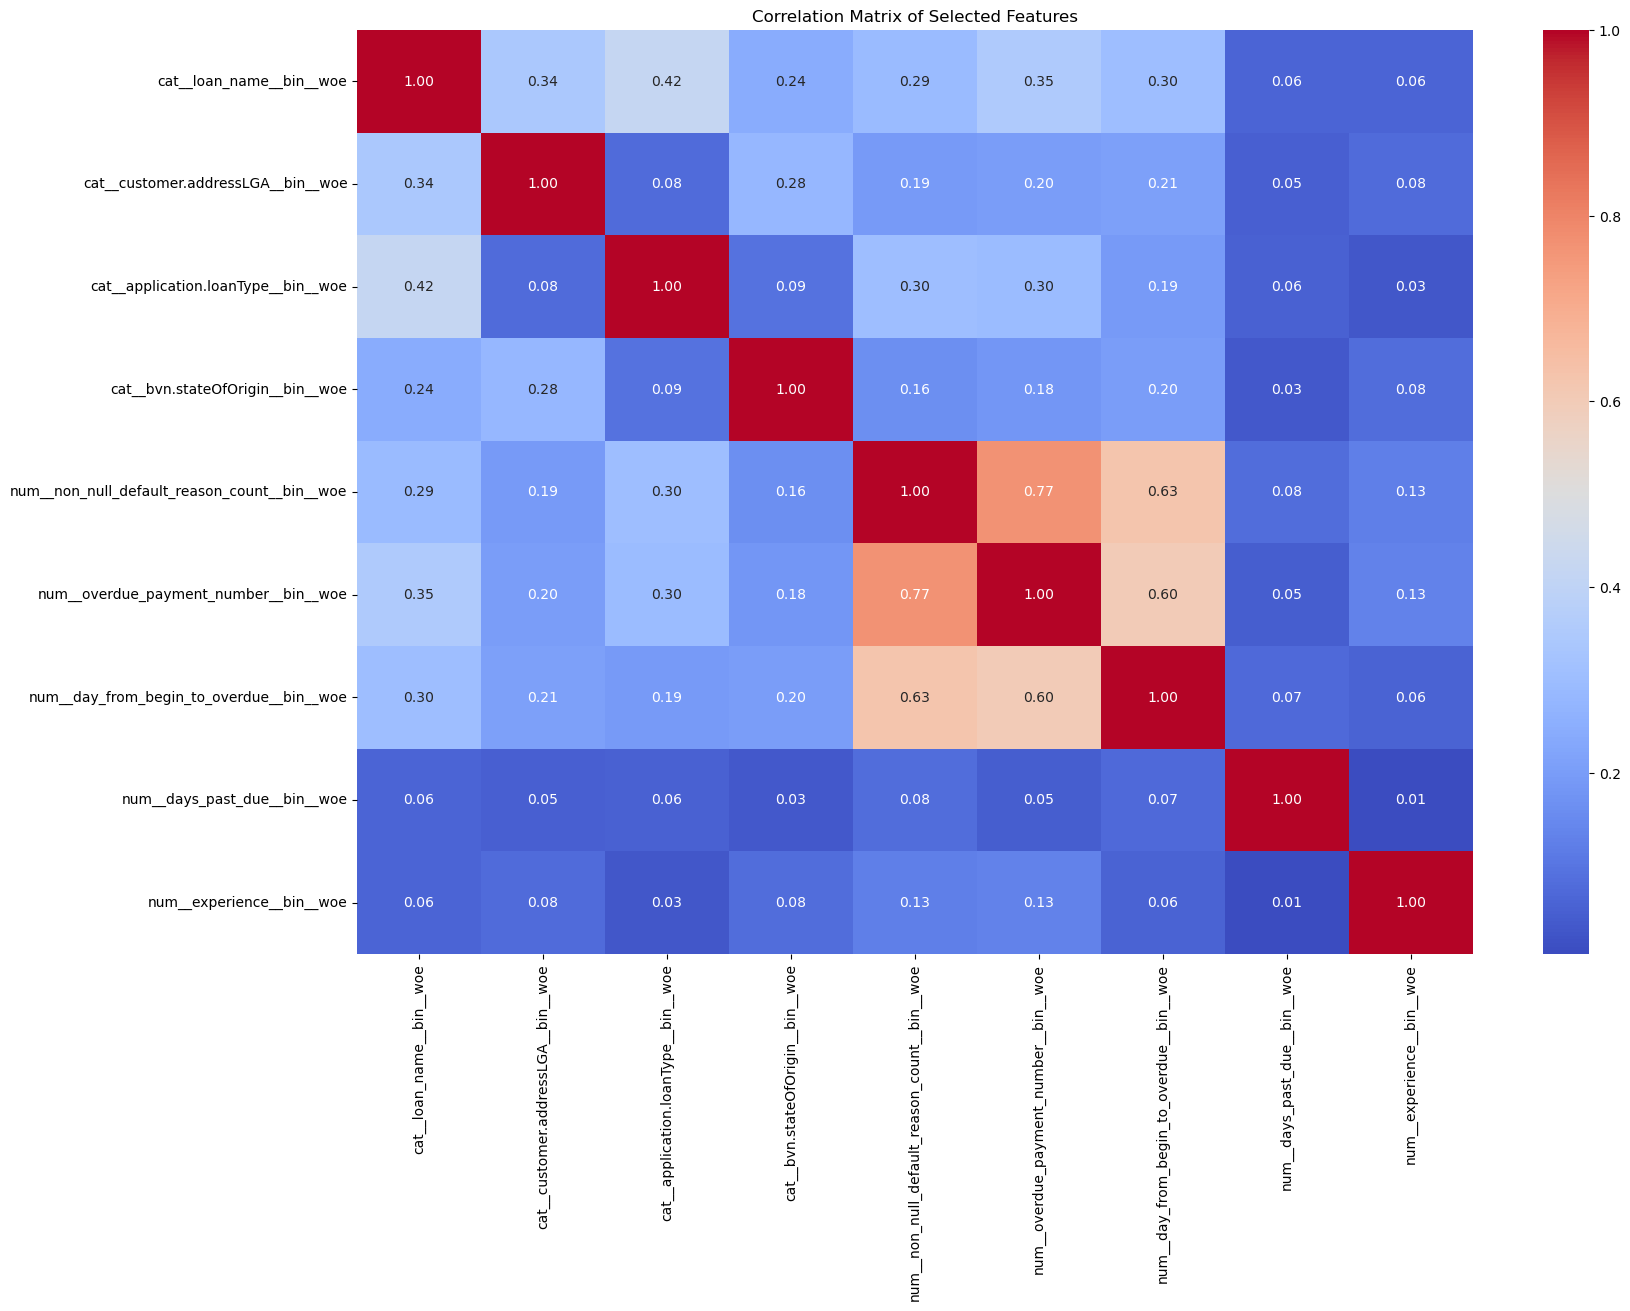

In [31]:
selected_features = clf.features_lst

X_selected = df8[selected_features].copy()

# Compute correlation matrix (absolute to focus on magnitude)
corr_matrix = X_selected.corr().abs()

# Visualize correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Selected Features")
plt.show()

# Model pipeline

## Single pipe

In [32]:
p = {

    "encoding_categorical__tol":0.001,
    "encoding_categorical__n_categories":1,
    
    "binning_cat__max_n_bins":4,
    "binning_cat__min_bin_size":0.15,
    "binning_cat__min_target_diff":0.02,

    "binning_num__max_n_bins":4,
    "binning_num__min_bin_size":0.15,
    "binning_num__min_target_diff":0.02,
    
    # "encoding_pairing__features_pattern":"^cat__.*__bin$",
    # "encoding_pairing__max_cardinality":4,
    # "encoding_pairing__iv_min":0.07,
    
    # "encoding_feature_elimination__correlation_thr":0.8,
    # "encoding_feature_elimination__constant_share_thr":0.97,
    # "encoding_feature_elimination__iv_min":0.01,
    # "encoding_feature_elimination__stab_num_thr": 0.03,
    # "encoding_feature_elimination__stab_cat_thr": 0.8,
    
    "encoding_feature_elimination_2__correlation_thr":0.8,
    "encoding_feature_elimination_2__constant_share_thr":0.97,
    "encoding_feature_elimination_2__iv_min":0.001,
    "encoding_feature_elimination_2__stab_num_thr": 0.03,
    "encoding_feature_elimination_2__stab_cat_thr": 0.8,
    "encoding_feature_elimination_2__cat_features_pattern": r"^$",
    "encoding_feature_elimination_2__num_features_pattern": r"[\w.]+__bin__woe$"
}

In [33]:
pipeline_model = Pipeline(steps=[
    ("features", SimpleFeaturesTransformer(
        num_features_dct,
        cat_features_dct,
        time_elapsed_features_lst,
        flag_features_lst
    )),
    
    ("encoding_categorical", CustomRareCategoriesTransformer()),
    #("encoding_feature_elimination", FeatureEliminationTransformer()), 
    ("binning_cat", BinningCategoriesTransformer_collection()),
    ("binning_num", BinningNumericalTransformer_collection()),
    #("encoding_pairing", PairedFeaturesTransformer()),       
    ("woe_tr", WoeEncoderTransformer_collection()),   
    ("encoding_feature_elimination_2", FeatureEliminationTransformer(
        num_features_pattern = r"[\w.]+__bin__woe$", 
        cat_features_pattern = r"^$")),
    ("model", 
     CustomLogisticRegressionClassifier()),
])

In [34]:
pipeline_model.set_params(**p)

Pipeline(steps=[('features',
                 SimpleFeaturesTransformer(cat_features_missings={'application.employmentSector': '__MISSING__',
                                                                  'application.employmentStatus': '__MISSING__',
                                                                  'application.existingCustomer': '__MISSING__',
                                                                  'application.lastLoanStatus': '__MISSING__',
                                                                  'application.loanType': '__MISSING__',
                                                                  'application.maritalStatus': '__MISSING__',
                                                                  'application.req...
                 BinningNumericalTransformer_collection(min_bin_size=0.15)),
                ('woe_tr', WoeEncoderTransformer_collection()),
                ('encoding_feature_elimination_2',
                 FeatureEliminationTransformer(cat_features_pattern='^$',
                                               constant_share_thr=0.97,
                                               iv_min=0.001,
                                               num_features_pattern='[\\w.]+__bin__woe$')),
                ('model',
                 CustomLogisticRegressionClassifier(features_pattern=re.compile('[\\w\\.]+__bin__woe$')))])

### Train/test split

In [35]:
df[TS_COL] = df['snap_date']    #.fillna(df['app_date'])

# Convert column to datetime
df[TS_COL] = pd.to_datetime(df[TS_COL], errors='coerce')

# Convert filter bounds to datetime
dt_start = datetime.strptime(DT_START, "%Y-%m-%d")
dt_end = datetime.strptime(DT_END, "%Y-%m-%d")

# Filter DataFrame
df = df_filter_by_dts(df, dt_start, dt_end, TS_COL)

# Extract only dates for min and max values
min_date, max_date = df[TS_COL].dt.date.min(), df[TS_COL].dt.date.max()
print(min_date, max_date)

2024-01-01 2025-03-01


In [36]:
df = df_filter_by_dts(df, dt_start, dt_end, TS_COL)
test_size = int(len(df) * 0.2)
test_size

df["sample"] = "train"
df.iloc[-test_size:, df.columns.get_loc("sample")] = "test"
test_size

582

In [37]:
df[df['sample'] == 'train'][TS_COL].max()

Timestamp('2025-03-01 00:00:00')

## Fit

In [38]:
pipeline_model.fit(
    X=df[df['sample'] == 'train'].drop(TARGET, axis=1),
    y=df[df['sample'] == 'train'][TARGET],
)

2025-05-13 23:54:14 - INFO - Simple features - Successfully finished.
2025-05-13 23:54:14 - INFO - Rare categories encoder - fit done
2025-05-13 23:54:14 - INFO - Rare categories encoder - transform done.
2025-05-13 23:54:14 - INFO - Cat. binning - fit done.
2025-05-13 23:54:14 - INFO - Cat. binning - tranfsorm done.
2025-05-13 23:54:37 - INFO - Num. binning - fit done.
2025-05-13 23:54:37 - INFO - Num. binning - tranfsorm done.
2025-05-13 23:54:38 - INFO - WOE cat encoder - fit done.
2025-05-13 23:54:38 - INFO - WOE cat encoder - transform done.
2025-05-13 23:54:38 - INFO - Feature elimination - initial features count:      50
2025-05-13 23:54:38 - INFO - Feature elimination - after dups dropping:         35
2025-05-13 23:54:38 - INFO - Feature elimination - after constants dropping:     34
2025-05-13 23:54:38 - INFO - Feature elimination - after decorrelation:     21
2025-05-13 23:54:38 - INFO - Feature elimination - after num non-stab dropping:     21
2025-05-13 23:54:38 - INFO - Fe

Pipeline(steps=[('features',
                 SimpleFeaturesTransformer(cat_features_missings={'application.employmentSector': '__MISSING__',
                                                                  'application.employmentStatus': '__MISSING__',
                                                                  'application.existingCustomer': '__MISSING__',
                                                                  'application.lastLoanStatus': '__MISSING__',
                                                                  'application.loanType': '__MISSING__',
                                                                  'application.maritalStatus': '__MISSING__',
                                                                  'application.req...
                                                                  'cat__bvn.stateOfOrigin__bin__woe',
                                                                  'num__num_collection__bin__woe',
                                                                  'num__overdue_payment_number__bin__woe',
                                                                  'num__application.effectiveInterestRate__bin__woe',
                                                                  'num__day_from_begin_to_overdue__bin__woe',
                                                                  'num__days_past_due__bin__woe',
                                                                  'num__loan_balance__bin__woe',
                                                                  'num__cb_avg.noOfLoans__bin__woe'],
                                                    features_pattern=re.compile('[\\w\\.]+__bin__woe$')))])

In [39]:
# Predict scores on all data set

df['y_pred'] = pipeline_model.predict(df.drop(TARGET, axis=1))

2025-05-13 23:54:39 - INFO - Simple features - Successfully finished.
2025-05-13 23:54:39 - INFO - Rare categories encoder - transform done.
2025-05-13 23:54:39 - INFO - Cat. binning - tranfsorm done.
2025-05-13 23:54:40 - INFO - Num. binning - tranfsorm done.
/home/jovyan/.local/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) num__cb_avg.outstandingloan__bin.
  warnings.warn(
2025-05-13 23:54:40 - INFO - WOE cat encoder - transform done.
2025-05-13 23:54:40 - INFO - Feature elimination - selected features count:   21.
2025-05-13 23:54:40 - INFO - Feature elimination - transform done.
2025-05-13 23:54:40 - INFO - Modeling: LogisticRegression - prediction done.


In [40]:
roc_auc_score(
    df[df['sample'] == 'test'][TARGET],
    df[df['sample'] == 'test']['y_pred']
)

0.8086114795390662

In [41]:
roc_auc_score(
    df[df['sample'] == 'train'][TARGET],
    df[df['sample'] == 'train']['y_pred']
)

0.8660512534340659

<AxesSubplot:>

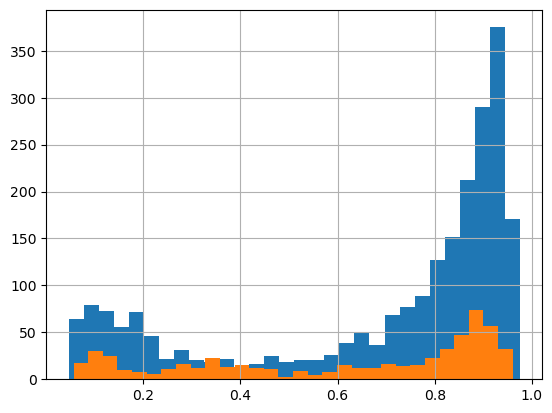

In [42]:
df[df['sample'] == 'train']['y_pred'].hist(bins=30)
df[df['sample'] == 'test']['y_pred'].hist(bins=30)

In [43]:
pipeline_model.steps[-1][1].features_lst

['cat__loan_name__bin__woe',
 'cat__customer.addressLGA__bin__woe',
 'cat__customer.employment.businessSector__bin__woe',
 'cat__bvn.stateOfOrigin__bin__woe',
 'num__num_collection__bin__woe',
 'num__overdue_payment_number__bin__woe',
 'num__application.effectiveInterestRate__bin__woe',
 'num__day_from_begin_to_overdue__bin__woe',
 'num__days_past_due__bin__woe',
 'num__loan_balance__bin__woe',
 'num__cb_avg.noOfLoans__bin__woe']

In [44]:
len(pipeline_model.steps[-1][1].features_lst)

11

In [45]:
model = pipeline_model.steps[-1][1].estimator

In [46]:
# Extract coefficients from the underlying statsmodels Logit model
coefs = pipeline_model.steps[-1][1].estimator.params

# Optionally, include p-values as well if you want to mimic a feature importance DataFrame
p_values = pipeline_model.steps[-1][1].estimator.pvalues

# Create a DataFrame
feature_importances_df = pd.DataFrame({
    'coef': coefs,
    'p_value': p_values
})

# Sort by the absolute value of the coefficient to get the most influential features at the top
feature_importances_df = feature_importances_df.reindex(
    feature_importances_df['coef'].abs().sort_values(ascending=False).index
).head(50)

print(feature_importances_df)

                                                       coef       p_value
num__days_past_due__bin__woe                       1.005897  2.631022e-04
num__application.effectiveInterestRate__bin__woe  -0.923693  7.209430e-06
num__day_from_begin_to_overdue__bin__woe           0.900321  3.188444e-48
cat__loan_name__bin__woe                           0.806436  3.014640e-21
const                                              0.768676  2.838460e-39
cat__bvn.stateOfOrigin__bin__woe                   0.412472  5.245015e-04
num__cb_avg.noOfLoans__bin__woe                    0.388352  9.939083e-02
cat__customer.employment.businessSector__bin__woe  0.336071  9.534006e-02
num__loan_balance__bin__woe                        0.323588  4.094123e-02
cat__customer.addressLGA__bin__woe                 0.310132  2.669693e-03
num__overdue_payment_number__bin__woe             -0.295774  3.963329e-03
num__num_collection__bin__woe                      0.217548  2.445669e-02


## Model unload (PICKLE)

In [47]:
pipeline_model

Pipeline(steps=[('features',
                 SimpleFeaturesTransformer(cat_features_missings={'application.employmentSector': '__MISSING__',
                                                                  'application.employmentStatus': '__MISSING__',
                                                                  'application.existingCustomer': '__MISSING__',
                                                                  'application.lastLoanStatus': '__MISSING__',
                                                                  'application.loanType': '__MISSING__',
                                                                  'application.maritalStatus': '__MISSING__',
                                                                  'application.req...
                                                                  'cat__bvn.stateOfOrigin__bin__woe',
                                                                  'num__num_collection__bin__woe',
                                                                  'num__overdue_payment_number__bin__woe',
                                                                  'num__application.effectiveInterestRate__bin__woe',
                                                                  'num__day_from_begin_to_overdue__bin__woe',
                                                                  'num__days_past_due__bin__woe',
                                                                  'num__loan_balance__bin__woe',
                                                                  'num__cb_avg.noOfLoans__bin__woe'],
                                                    features_pattern=re.compile('[\\w\\.]+__bin__woe$')))])

In [48]:
joblib.dump(pipeline_model, 'cs_internal_SEL_BETA_5_30.joblib')

['cs_internal_SEL_BETA_5_30.joblib']

In [49]:
from datetime import datetime

datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2025-05-13 23:54:40'

## Import helpers 

In [1]:
# for import custom libraries

import sys
sys.path.append('../libs')

In [2]:
# custom library with our functions 

from general_lib import (parse_json_field, 
                        df_filter_by_dts, 
                        yymm, 
                        yyww, 
                        add_yy_mm, 
                        add_ww_mm_date)
from plotter_lib import (plot_fpd_by_time, 
                        plot_roc, 
                        plot_mean_target_in_time, 
                        plot_correlation_with_target,
                        plot_roc_fixed)
from optbin_lib import (get_values_map, 
                        get_optbin_info_cat, 
                        get_optbin_info_num)
from metrics_lib import (calculate_information_values, 
                        get_num_feature_stability_index, 
                        get_cat_feature_stability_index)

# Model metrics 

## Features drift

In [78]:
pipeline_data = Pipeline(steps=pipeline_model.steps[:-1])

# pipeline_data.fit(
#     X=df[df['sample'] == 'train'].drop(TARGET, axis=1),
#     y=df[df['sample'] == 'train'][TARGET]
# )

In [79]:
df_features_drift = pipeline_data.transform(
    X=df[df['sample'] == 'train']
)

2025-04-17 02:56:40 - INFO - Simple features - Successfully finished.
2025-04-17 02:56:40 - INFO - Rare categories encoder - transform done.
2025-04-17 02:56:40 - INFO - Cat. binning - tranfsorm done.


Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 21900000.0, 122050000.0, 328800000.0, inf]
Feature: num__loan_num, Bins: [1.0, 2.5, inf]
Feature: num__num_collection, Bins: [1.0, 15.5, 42.5, 58.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 131206.640625, 458263.25, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 381590.5, 1101313.0625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 0.11499999836087227, 151340.78125, 648502.90625, inf]
Feature: num__number_of_kept_promises, Bins: [0.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [0.0, 1.5, 2.5, 4.5, inf]
Feature: num_

2025-04-17 02:56:41 - INFO - Num. binning - tranfsorm done.
2025-04-17 02:56:41 - INFO - WOE cat encoder - transform done.
2025-04-17 02:56:41 - INFO - Feature elimination - selected features count:   27.
2025-04-17 02:56:41 - INFO - Feature elimination - transform done.


Feature: num__salary_median, Bins: [0.0, inf]
Feature: num__cb_avg.outstandingloan, Bins: [-139875.64, 1712.0, 516846.71875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [-1.0, inf]
Feature: num__cb_avg.currentDPD, Bins: [-1.0, -0.5, inf]
Feature: num__age, Bins: [22.0, 29.5, 36.5, 42.5, inf]
Feature: num__experience, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfLoans, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-149.0, 4.5, 18.5, 38.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-82.0, 1.5, 18.5, 61.5, inf]


In [80]:
df_features_drift[TARGET] = df[df['sample'] == 'train'][TARGET].values
df_features_drift['dt_month'] = df[df['sample'] == 'train']['dt_month'].values
df_features_drift['dt_week'] = df[df['sample'] == 'train']['dt_week'].values

In [81]:
df_features_drift['dt_month'].min(), df_features_drift['dt_month'].max()

ts_min, ts_max = (
    df[df['sample'] == 'train'][TS_COL].min(),
    df[df['sample'] == 'train'][TS_COL].max()
)
ts_min, ts_max

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-03-01 00:00:00'))

In [82]:
pipeline_model.steps[-1][1].features_lst

['cat__loan_name__bin__woe',
 'cat__customer.addressLGA__bin__woe',
 'cat__customer.employment.employerLGA__bin__woe',
 'cat__customer.employment.businessSector__bin__woe',
 'cat__application.loanType__bin__woe',
 'cat__application.requestedLoanAmount__bin__woe',
 'cat__bvn.stateOfOrigin__bin__woe',
 'num__loan_amt_x_tenor__bin__woe',
 'num__num_collection__bin__woe',
 'num__promised_amount__bin__woe',
 'num__paid_promised_amount__bin__woe',
 'num__days_since_last_promise__bin__woe',
 'num__application.effectiveInterestRate__bin__woe',
 'num__days_past_due__bin__woe',
 'num__cb_avg.currentDPD__bin__woe',
 'num__age__bin__woe',
 'num__days_from_begin_to_overdue_pd__bin__woe']

In [83]:
f_num_list = [f for f in pipeline_model.steps[-1][1].features_lst if f.endswith('__bin__woe')]

cat__loan_name__bin__woe      : 0.27218225914995475
cat__customer.addressLGA__bin__woe: 0.2910643374456434
cat__customer.employment.employerLGA__bin__woe: 0.2515982095495813
cat__customer.employment.businessSector__bin__woe: 0.1520616193782509
cat__application.loanType__bin__woe: 0.17741293682794024
cat__application.requestedLoanAmount__bin__woe: 0.3698149780535116
cat__bvn.stateOfOrigin__bin__woe: 0.2545184439123196
num__loan_amt_x_tenor__bin__woe: 0.2875046706287976
num__num_collection__bin__woe : 0.11882794337567369
num__promised_amount__bin__woe: 0.31109496389034247
num__paid_promised_amount__bin__woe: 0.3194670258941277
num__days_since_last_promise__bin__woe: 0.357157880503677
num__application.effectiveInterestRate__bin__woe: 0.24917081839154204
num__days_past_due__bin__woe  : 0.14740766792484575
num__cb_avg.currentDPD__bin__woe: 0.1301000095383181
num__age__bin__woe            : 0.19319497797865773
num__days_from_begin_to_overdue_pd__bin__woe: 0.41801615733132325
cat__loan_name__

/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


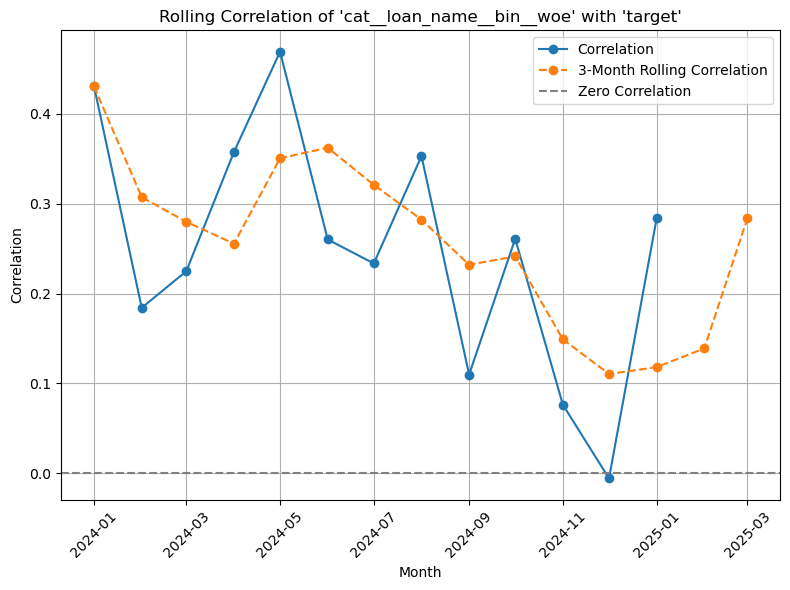

cat__customer.addressLGA__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


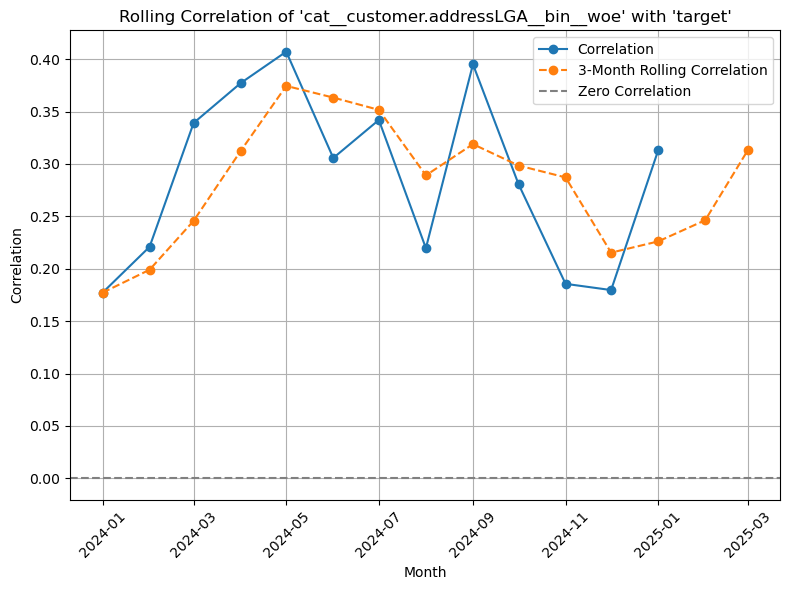

cat__customer.employment.employerLGA__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


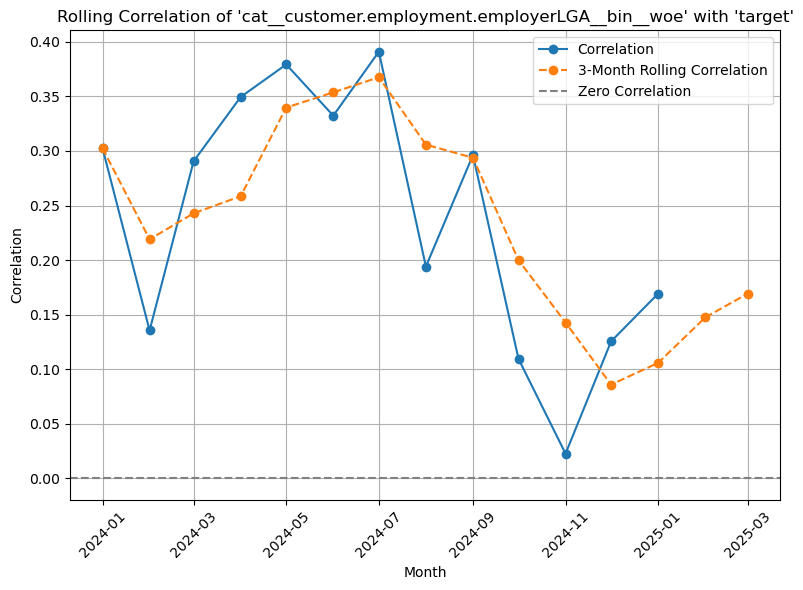

cat__customer.employment.businessSector__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


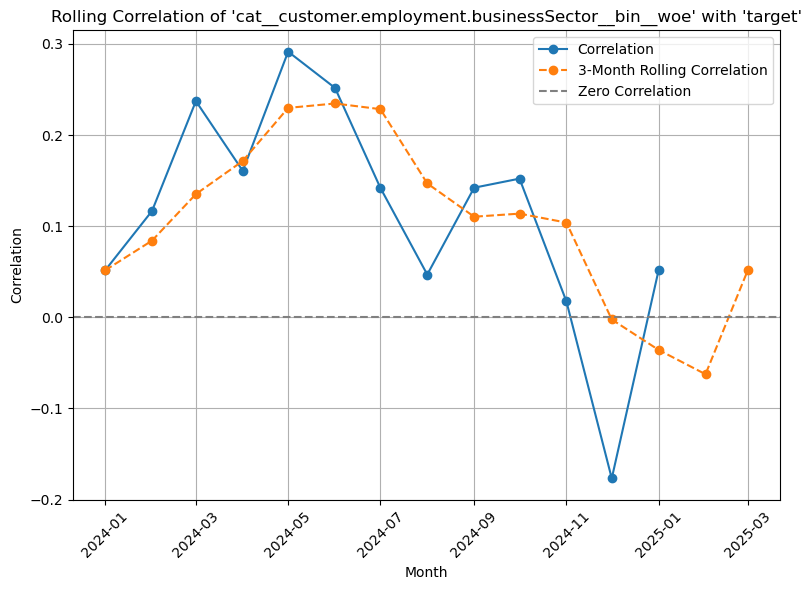

cat__application.loanType__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


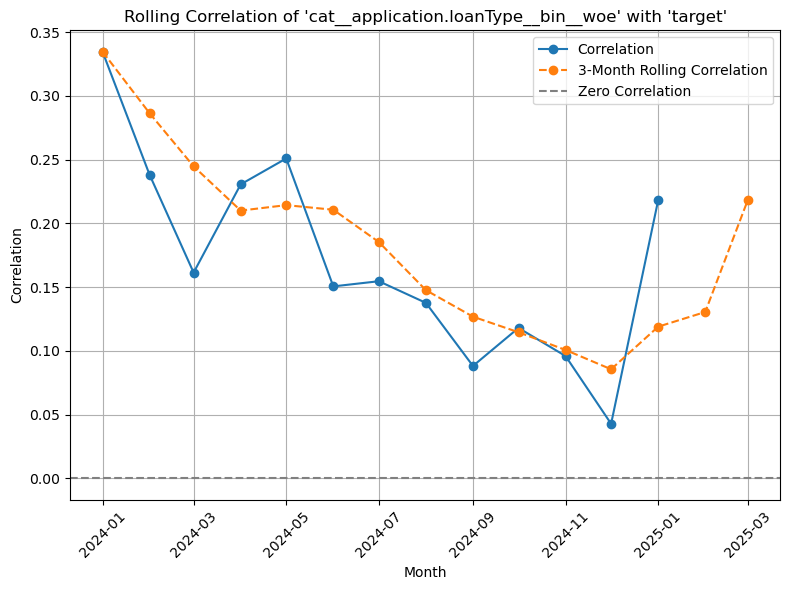

cat__application.requestedLoanAmount__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


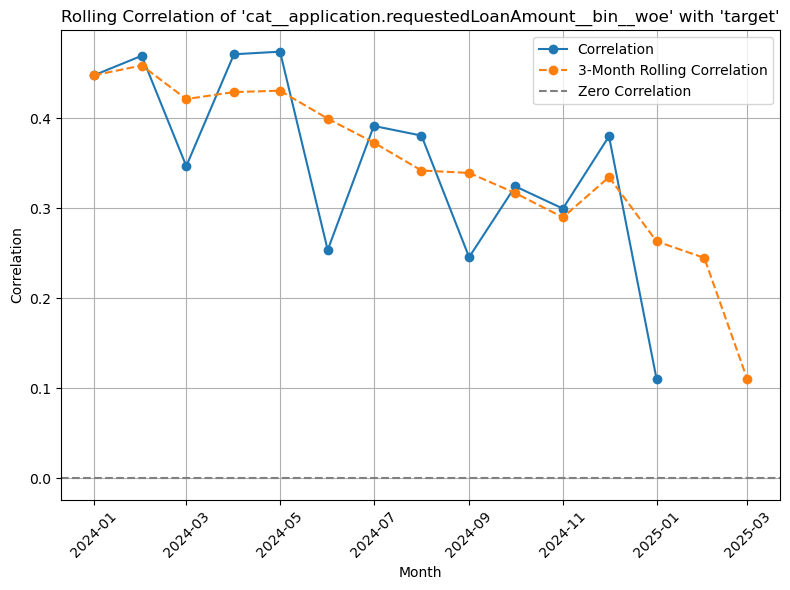

cat__bvn.stateOfOrigin__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


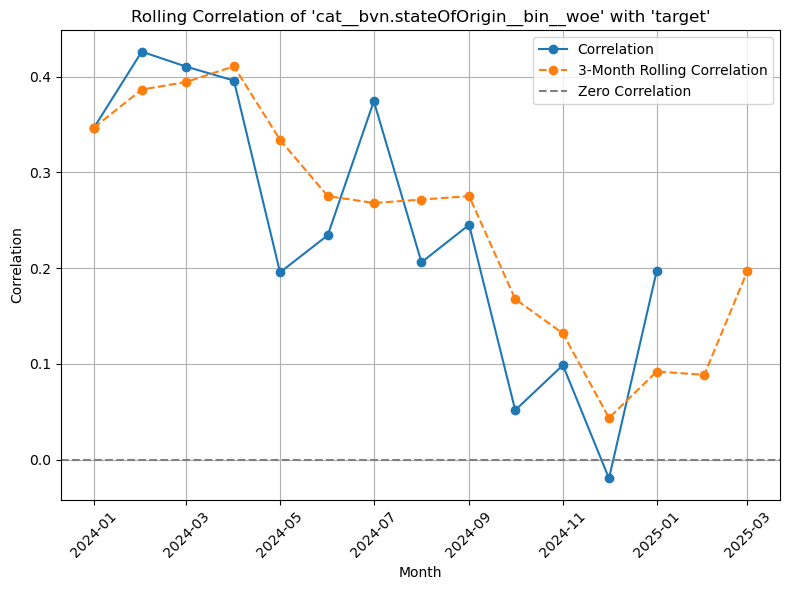

num__loan_amt_x_tenor__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


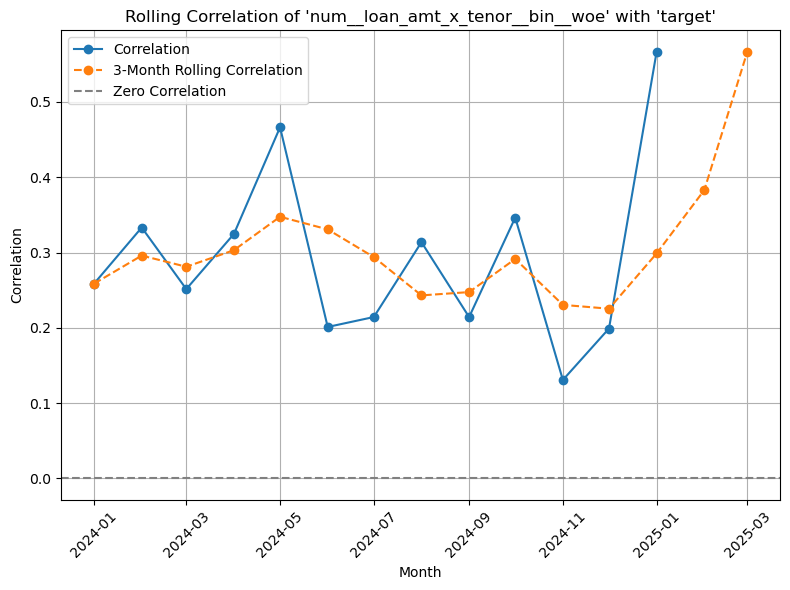

num__num_collection__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


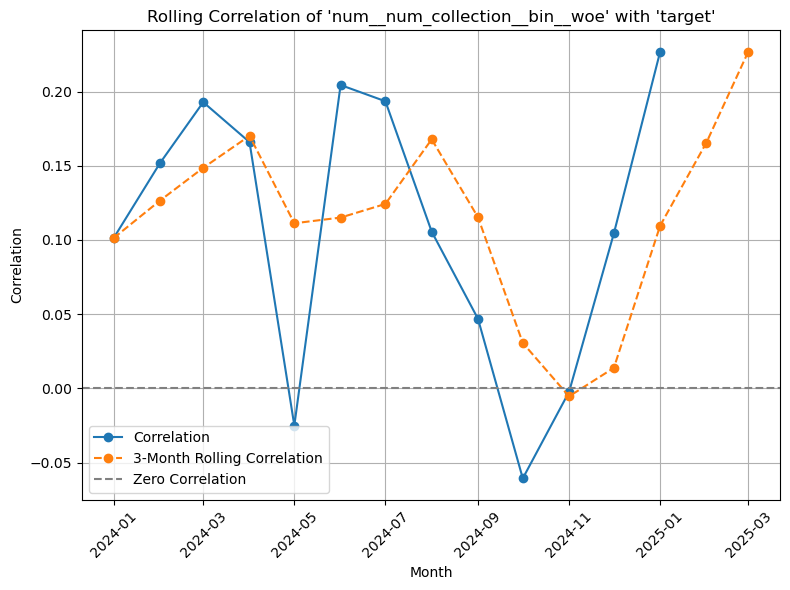

num__promised_amount__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


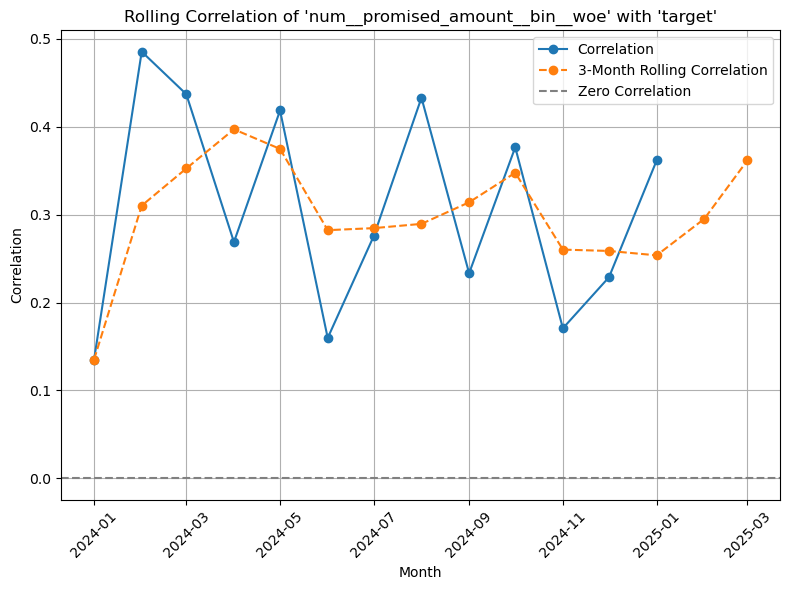

num__paid_promised_amount__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


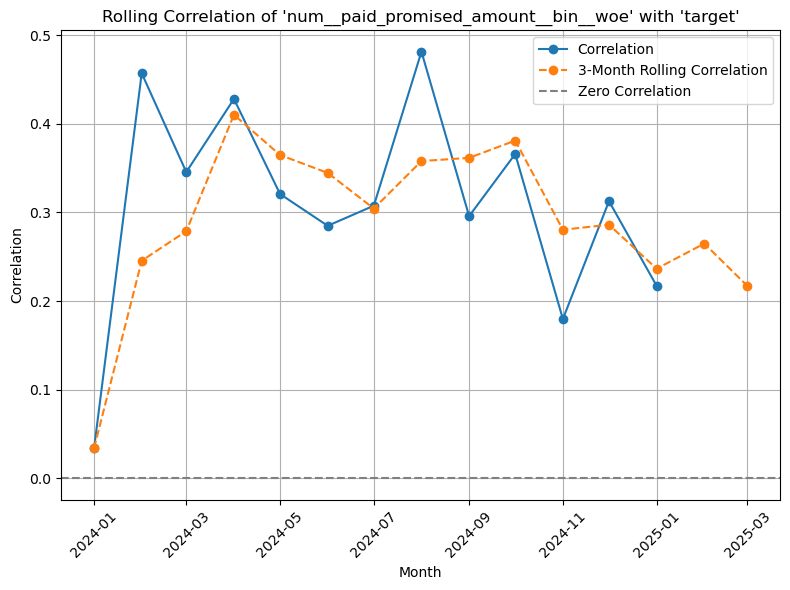

num__days_since_last_promise__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


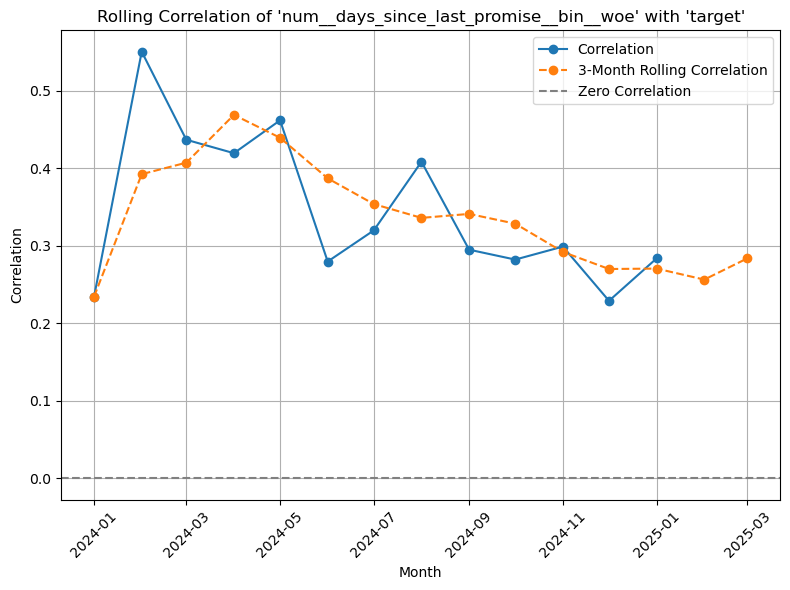

num__application.effectiveInterestRate__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


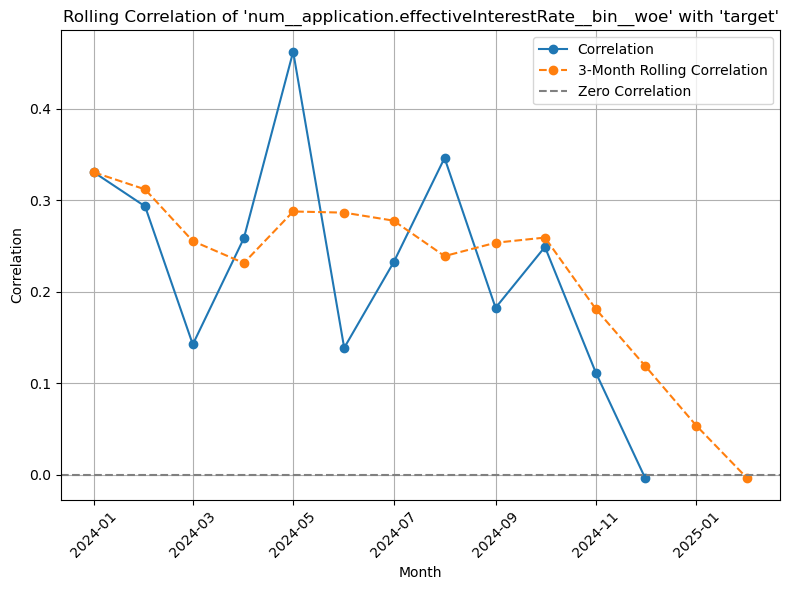

num__days_past_due__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


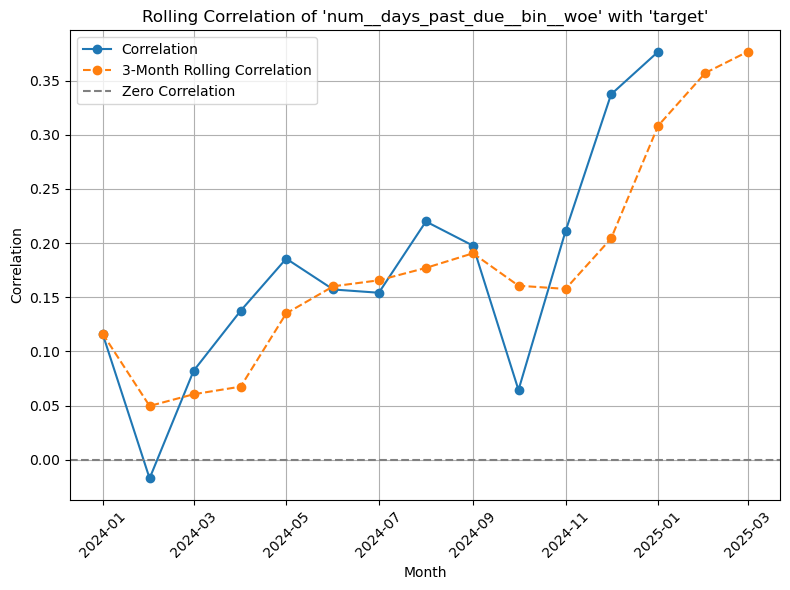

num__cb_avg.currentDPD__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


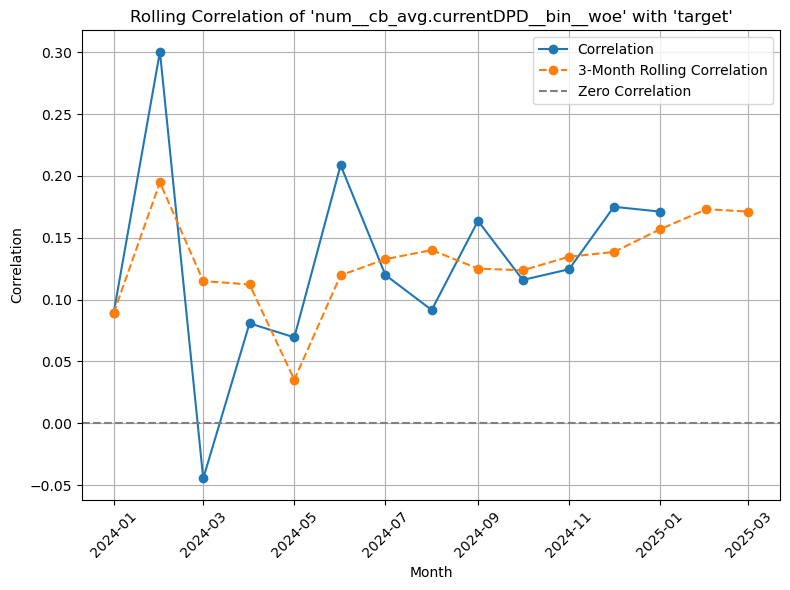

num__age__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


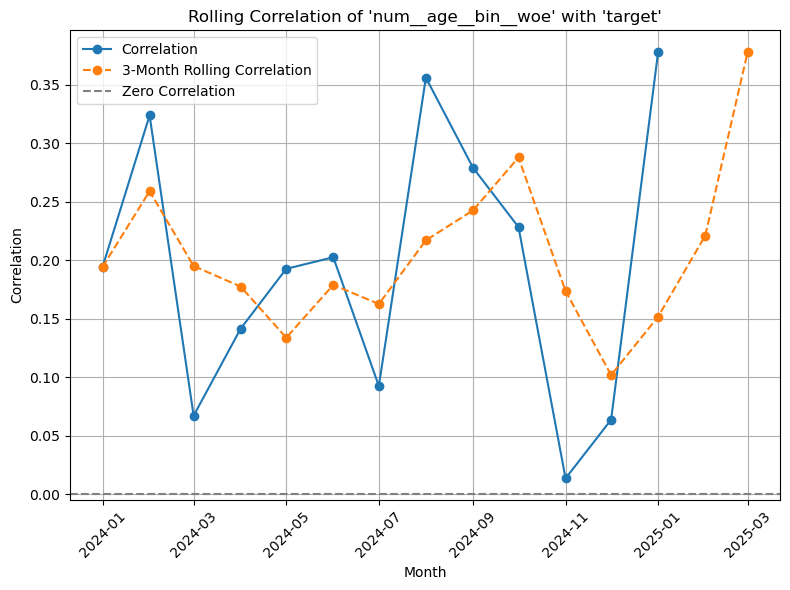

num__days_from_begin_to_overdue_pd__bin__woe
0.41801615733132325


/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


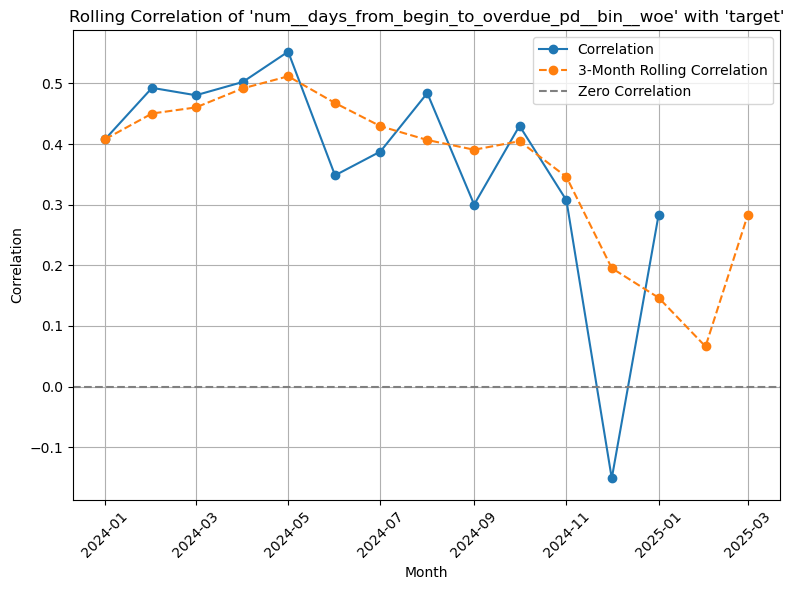

In [84]:
for f in f_num_list:
    
    instab_index = get_num_feature_stability_index(
        df_features_drift, 
        'dt_month', 
        f, 
        TARGET
    )
    print(f"{f:30}: {instab_index:5}")

for f in f_num_list:
    print(f)
    print(instab_index)
    plot_correlation_with_target(
        df_features_drift, 
        'dt_month', 
        f, 
        TARGET
    )

In [85]:
columns = pipeline_model.steps[-1][1].features_lst
print(columns)
prefinal_columns = [col.replace('cat__', '')
                     .replace('num__time_elapsed__', '')
                     .replace('num__', '')
                     .replace('__bin__woe', '')
                 for col in columns]
prefinal_columns = [col for col in prefinal_columns if col != 'input.salaryservice.monthlyElectricitySpending6' and col != 'input.salaryservice.agentSalaryDate4' and col != 'input.salaryservice.minBalanceWk' and col != 'input.salaryservice.closingBalance' and col != 'input.salaryservice.dayDiffDebit']

['cat__loan_name__bin__woe', 'cat__customer.addressLGA__bin__woe', 'cat__customer.employment.employerLGA__bin__woe', 'cat__customer.employment.businessSector__bin__woe', 'cat__application.loanType__bin__woe', 'cat__application.requestedLoanAmount__bin__woe', 'cat__bvn.stateOfOrigin__bin__woe', 'num__loan_amt_x_tenor__bin__woe', 'num__num_collection__bin__woe', 'num__promised_amount__bin__woe', 'num__paid_promised_amount__bin__woe', 'num__days_since_last_promise__bin__woe', 'num__application.effectiveInterestRate__bin__woe', 'num__days_past_due__bin__woe', 'num__cb_avg.currentDPD__bin__woe', 'num__age__bin__woe', 'num__days_from_begin_to_overdue_pd__bin__woe']


In [86]:
prefinal_columns

['loan_name',
 'customer.addressLGA',
 'customer.employment.employerLGA',
 'customer.employment.businessSector',
 'application.loanType',
 'application.requestedLoanAmount',
 'bvn.stateOfOrigin',
 'loan_amt_x_tenor',
 'num_collection',
 'promised_amount',
 'paid_promised_amount',
 'days_since_last_promise',
 'application.effectiveInterestRate',
 'days_past_due',
 'cb_avg.currentDPD',
 'age',
 'days_from_begin_to_overdue_pd']

## ROC-AUC

In [87]:
roc_auc_score(
    df[df['sample'] == 'test'][TARGET],
    df[df['sample'] == 'test']['y_pred']
)

0.7014591141597719

In [88]:
roc_auc_score(
    df[df['sample'] == 'train'][TARGET],
    df[df['sample'] == 'train']['y_pred']
)

0.8262048184073209

<AxesSubplot:>

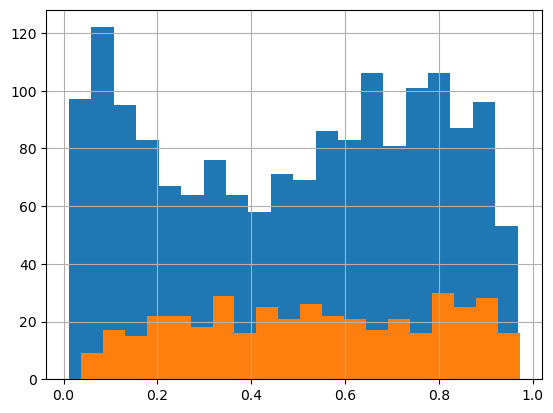

In [89]:
df[df['sample'] == 'train']['y_pred'].hist(bins=20)
df[df['sample'] == 'test']['y_pred'].hist(bins=20)

In [90]:
def plot_roc(model, X_train=None, y_train=None, X_test=None, y_test=None, save_plot=False):

    # model_name = str(model.__class__).split('.')[-1][:-2]
    
    plt.figure()
    
    if ((X_train is not None) and (y_train is not None)):
        y_pred_train = model.predict(X_train)
        
        roc_auc_train = roc_auc_score(y_train, y_pred_train)
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
        
        plt.plot(fpr_train, tpr_train, label='train (%0.3f)' % roc_auc_train)  
        
    if ((X_test is not None) and (y_test is not None)):
        y_pred_test = model.predict(X_test)
        
        roc_auc_test = roc_auc_score(y_test, y_pred_test)
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
        
        plt.plot(fpr_test, tpr_test, label='test (%0.3f)' % roc_auc_test) 

    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC AUC \n \n N features: {len(model.steps[-1][1].features_lst)}')
    plt.legend(loc="lower right")
    plt.grid()

    plt.show()

2025-04-17 02:56:45 - INFO - Simple features - Successfully finished.
2025-04-17 02:56:45 - INFO - Rare categories encoder - transform done.
2025-04-17 02:56:45 - INFO - Cat. binning - tranfsorm done.


Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 21900000.0, 122050000.0, 328800000.0, inf]
Feature: num__loan_num, Bins: [1.0, 2.5, inf]
Feature: num__num_collection, Bins: [1.0, 15.5, 42.5, 58.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 131206.640625, 458263.25, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 381590.5, 1101313.0625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 0.11499999836087227, 151340.78125, 648502.90625, inf]
Feature: num__number_of_kept_promises, Bins: [0.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [0.0, 1.5, 2.5, 4.5, inf]
Feature: num_

2025-04-17 02:56:46 - INFO - Num. binning - tranfsorm done.
2025-04-17 02:56:46 - INFO - WOE cat encoder - transform done.
2025-04-17 02:56:46 - INFO - Feature elimination - selected features count:   27.
2025-04-17 02:56:46 - INFO - Feature elimination - transform done.
2025-04-17 02:56:46 - INFO - Modeling: LogisticRegression - prediction done.


Feature: num__salary_median, Bins: [0.0, inf]
Feature: num__cb_avg.outstandingloan, Bins: [-139875.64, 1712.0, 516846.71875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [-1.0, inf]
Feature: num__cb_avg.currentDPD, Bins: [-1.0, -0.5, inf]
Feature: num__age, Bins: [22.0, 29.5, 36.5, 42.5, inf]
Feature: num__experience, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfLoans, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-149.0, 4.5, 18.5, 38.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-82.0, 1.5, 18.5, 61.5, inf]


2025-04-17 02:56:46 - INFO - Simple features - Successfully finished.
2025-04-17 02:56:46 - INFO - Rare categories encoder - transform done.
2025-04-17 02:56:46 - INFO - Cat. binning - tranfsorm done.
2025-04-17 02:56:46 - INFO - Num. binning - tranfsorm done.
/home/jovyan/.local/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) cat__customer.employment.businessSector__bin, cat__application.existingCustomer__bin, cat__application.loanType__bin, cat__application.employmentSector__bin, cat__application.employmentStatus__bin, cat__application.maritalStatus__bin, cat__cb_avg.highestRepaymentStatus__bin, num__num_collection__bin, num__non_null_default_reason_count__bin, num__number_of_kept_promises__bin, num__total_number_of_promises__bin, num__cb_avg.outstandingloan__bin, num__age__bin.
  warnings.warn(
2025-04-17 02:56:46 - INFO - WOE cat encoder - transform done.
2025-04-17 02:56:46 - IN

Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 21900000.0, 122050000.0, 328800000.0, inf]
Feature: num__loan_num, Bins: [1.0, 2.5, inf]
Feature: num__num_collection, Bins: [1.0, 15.5, 42.5, 58.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 131206.640625, 458263.25, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 381590.5, 1101313.0625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 0.11499999836087227, 151340.78125, 648502.90625, inf]
Feature: num__number_of_kept_promises, Bins: [0.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [0.0, 1.5, 2.5, 4.5, inf]
Feature: num_

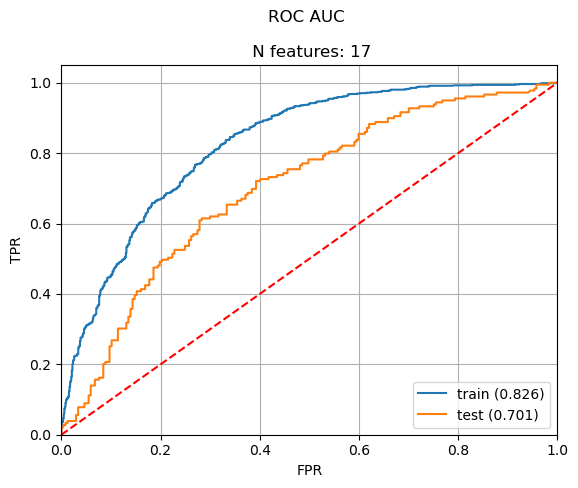

In [91]:
plot_roc(pipeline_model, 
         
    # df_oot.drop(TARGET, axis=1), 
    # df_oot[TARGET], 

    df[df['sample'] == 'train'].drop(TARGET, axis=1), 
    df[df['sample'] == 'train'][TARGET],

    df[df['sample'] == 'test'].drop(TARGET, axis=1), 
    df[df['sample'] == 'test'][TARGET],
)

## Cross validation

In [92]:
def cross_val_predict(estimator, X, y, cv=5, early_stopping_rounds=8):
    # Initialize predictions array
    n_samples = len(X)
    #predictions = np.zeros((n_samples, 2))  # Assuming binary classification
    predictions = np.zeros(n_samples)       #!!!!!!My changing

    # Perform cross-validation
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    for train_index, test_index in kf.split(X, y):
        # Split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        try:
            # Fit estimator on training data with early stopping
            estimator.fit(
                X_train,
                y_train,
                model__early_stopping_rounds=early_stopping_rounds,  # Pass early stopping rounds
            )

            # Predict on test data
            y_pred = estimator.predict(X_test)
            # Update predictions array
            predictions[test_index] = y_pred
            
        except Exception as e:
            logger.error(f"Error during fitting or predicting: {e}")
            
    return predictions
    
cv_predictions = cross_val_predict(pipeline_model, X=df.drop(TARGET, axis=1), 
                                   y=df[TARGET], cv=5)

2025-04-17 02:56:46 - INFO - Simple features - Successfully finished.
2025-04-17 02:56:46 - INFO - Rare categories encoder - fit done
2025-04-17 02:56:46 - INFO - Rare categories encoder - transform done.
2025-04-17 02:56:46 - INFO - Cat. binning - fit done.
2025-04-17 02:56:46 - INFO - Cat. binning - tranfsorm done.
2025-04-17 02:57:27 - INFO - Num. binning - fit done.


Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 29166000.0, 122050000.0, 266000000.0, inf]
Feature: num__loan_num, Bins: [1.0, 2.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 365.8699951171875, 127678.625, 453312.03125, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 3.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 381932.640625, 1101313.0625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 68.28000259399414, 149980.09375, 648502.90625, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: nu

2025-04-17 02:57:27 - INFO - Num. binning - tranfsorm done.


Feature: num__salary_median, Bins: [0.0, 225000.0, inf]
Feature: num__cb_avg.outstandingloan, Bins: [-608497.74, 495.9599914550781, 662357.5, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.currentDPD, Bins: [-1.0, -0.5, inf]
Feature: num__age, Bins: [-1.0, 29.5, 36.5, 41.5, inf]
Feature: num__experience, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-149.0, 13.0, 39.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-82.0, 18.5, 44.5, 76.5, inf]


2025-04-17 02:57:27 - INFO - WOE cat encoder - fit done.
2025-04-17 02:57:27 - INFO - WOE cat encoder - transform done.
2025-04-17 02:57:27 - INFO - Feature elimination - initial features count:      51
2025-04-17 02:57:27 - INFO - Feature elimination - after dups dropping:         38
2025-04-17 02:57:27 - INFO - Feature elimination - after constants dropping:     37
2025-04-17 02:57:27 - INFO - Feature elimination - after decorrelation:     29
2025-04-17 02:57:28 - INFO - Feature elimination - after num non-stab dropping:     29
2025-04-17 02:57:28 - INFO - Feature elimination - fit done.
2025-04-17 02:57:28 - INFO - Feature elimination - selected features count:   29.
2025-04-17 02:57:28 - INFO - Feature elimination - transform done.
2025-04-17 02:57:28 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-04-17 02:57:28 - INFO - Modeling: LogisticRegression - features amount:17
2025-04-17 02:57:28 - INFO - Modeling: LogisticRegression - fit done.
2025-04-17 02:57:28

Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 29166000.0, 122050000.0, 266000000.0, inf]
Feature: num__loan_num, Bins: [1.0, 2.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 365.8699951171875, 127678.625, 453312.03125, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 3.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 381932.640625, 1101313.0625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 68.28000259399414, 149980.09375, 648502.90625, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: nu

2025-04-17 02:57:29 - INFO - Simple features - Successfully finished.
2025-04-17 02:57:29 - INFO - Rare categories encoder - fit done
2025-04-17 02:57:29 - INFO - Rare categories encoder - transform done.
2025-04-17 02:57:29 - INFO - Cat. binning - fit done.
2025-04-17 02:57:29 - INFO - Cat. binning - tranfsorm done.
2025-04-17 02:58:08 - INFO - Num. binning - fit done.


Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 35770000.0, 122050000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 15.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 149259.984375, 458263.25, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 7.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 95163.05859375, 389401.0, 1103005.375, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 109.31499862670898, 149980.09375, 617526.15625, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__days_since_

2025-04-17 02:58:08 - INFO - Num. binning - tranfsorm done.


Feature: num__salary_median, Bins: [0.0, 1839752.6875, inf]
Feature: num__cb_avg.outstandingloan, Bins: [-149999.96, 1849.5, 516846.71875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.currentDPD, Bins: [-1.0, -0.5, inf]
Feature: num__age, Bins: [-1.0, 29.5, 34.5, 38.5, inf]
Feature: num__experience, Bins: [-1.0, 2.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, -0.5, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-149.0, 4.5, 18.5, 37.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-82.0, 18.5, 55.5, 76.5, inf]


2025-04-17 02:58:08 - INFO - WOE cat encoder - fit done.
2025-04-17 02:58:08 - INFO - WOE cat encoder - transform done.
2025-04-17 02:58:08 - INFO - Feature elimination - initial features count:      51
2025-04-17 02:58:08 - INFO - Feature elimination - after dups dropping:         41
2025-04-17 02:58:09 - INFO - Feature elimination - after constants dropping:     40
2025-04-17 02:58:09 - INFO - Feature elimination - after decorrelation:     29
2025-04-17 02:58:09 - INFO - Feature elimination - after num non-stab dropping:     29
2025-04-17 02:58:09 - INFO - Feature elimination - fit done.
2025-04-17 02:58:09 - INFO - Feature elimination - selected features count:   29.
2025-04-17 02:58:09 - INFO - Feature elimination - transform done.
2025-04-17 02:58:09 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-04-17 02:58:09 - INFO - Modeling: LogisticRegression - features amount:17
2025-04-17 02:58:09 - INFO - Modeling: LogisticRegression - fit done.
2025-04-17 02:58:09

Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 35770000.0, 122050000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 15.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 149259.984375, 458263.25, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 7.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 95163.05859375, 389401.0, 1103005.375, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 109.31499862670898, 149980.09375, 617526.15625, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__days_since_

2025-04-17 02:58:10 - INFO - Simple features - Successfully finished.
2025-04-17 02:58:10 - INFO - Rare categories encoder - fit done
2025-04-17 02:58:10 - INFO - Rare categories encoder - transform done.
2025-04-17 02:58:10 - INFO - Cat. binning - fit done.
2025-04-17 02:58:10 - INFO - Cat. binning - tranfsorm done.
2025-04-17 02:58:47 - INFO - Num. binning - fit done.


Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 21600000.0, 122050000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 365.8699951171875, 107721.875, 458263.25, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 3.5, 7.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 5.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 388703.953125, 826793.78125, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 109.31499862670898, 151237.28125, 591335.75, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__days_since

2025-04-17 02:58:47 - INFO - Num. binning - tranfsorm done.


Feature: num__salary_median, Bins: [0.0, 1839752.6875, inf]
Feature: num__cb_avg.outstandingloan, Bins: [-608497.74, 4900.764892578125, 505008.96875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.currentDPD, Bins: [-1.0, -0.5, inf]
Feature: num__age, Bins: [-1.0, 29.5, 34.5, 40.5, inf]
Feature: num__experience, Bins: [-1.0, 1.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, -0.5, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-149.0, 4.5, 18.5, 40.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-82.0, 12.5, 33.5, 60.5, inf]


2025-04-17 02:58:48 - INFO - WOE cat encoder - fit done.
2025-04-17 02:58:48 - INFO - WOE cat encoder - transform done.
2025-04-17 02:58:48 - INFO - Feature elimination - initial features count:      51
2025-04-17 02:58:48 - INFO - Feature elimination - after dups dropping:         41
2025-04-17 02:58:48 - INFO - Feature elimination - after constants dropping:     40
2025-04-17 02:58:48 - INFO - Feature elimination - after decorrelation:     29
2025-04-17 02:58:48 - INFO - Feature elimination - after num non-stab dropping:     29
2025-04-17 02:58:48 - INFO - Feature elimination - fit done.
2025-04-17 02:58:48 - INFO - Feature elimination - selected features count:   29.
2025-04-17 02:58:48 - INFO - Feature elimination - transform done.
2025-04-17 02:58:48 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-04-17 02:58:48 - ERROR - Error during fitting or predicting: "['num__paid_promised_amount__bin__woe'] not in index"
2025-04-17 02:58:49 - INFO - Simple features - 

Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 32045000.0, 132550000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 250.1999969482422, 131206.640625, 458263.25, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 3.5, 7.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 20.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 96314.5546875, 382718.15625, 1099510.5625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 14750.68017578125, 149980.09375, 636653.09375, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 2.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__days_si

2025-04-17 02:59:24 - INFO - Num. binning - tranfsorm done.


Feature: num__salary_median, Bins: [0.0, inf]
Feature: num__cb_avg.outstandingloan, Bins: [-608497.74, 38911.0, 662357.5, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.currentDPD, Bins: [-1.0, -0.5, inf]
Feature: num__age, Bins: [-1.0, 29.5, 36.5, inf]
Feature: num__experience, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, -0.5, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-149.0, 4.5, 17.5, 39.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-58.0, 18.5, 33.5, 60.5, inf]


2025-04-17 02:59:24 - INFO - WOE cat encoder - fit done.
2025-04-17 02:59:24 - INFO - WOE cat encoder - transform done.
2025-04-17 02:59:24 - INFO - Feature elimination - initial features count:      51
2025-04-17 02:59:24 - INFO - Feature elimination - after dups dropping:         40
2025-04-17 02:59:24 - INFO - Feature elimination - after constants dropping:     39
2025-04-17 02:59:24 - INFO - Feature elimination - after decorrelation:     29
2025-04-17 02:59:25 - INFO - Feature elimination - after num non-stab dropping:     29
2025-04-17 02:59:25 - INFO - Feature elimination - fit done.
2025-04-17 02:59:25 - INFO - Feature elimination - selected features count:   29.
2025-04-17 02:59:25 - INFO - Feature elimination - transform done.
2025-04-17 02:59:25 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-04-17 02:59:25 - INFO - Modeling: LogisticRegression - features amount:17
2025-04-17 02:59:25 - INFO - Modeling: LogisticRegression - fit done.
2025-04-17 02:59:25

Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 32045000.0, 132550000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 250.1999969482422, 131206.640625, 458263.25, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 3.5, 7.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 20.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 96314.5546875, 382718.15625, 1099510.5625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 14750.68017578125, 149980.09375, 636653.09375, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 2.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__days_si

2025-04-17 02:59:25 - INFO - Modeling: LogisticRegression - prediction done.
2025-04-17 02:59:25 - INFO - Simple features - Successfully finished.
2025-04-17 02:59:25 - INFO - Rare categories encoder - fit done
2025-04-17 02:59:25 - INFO - Rare categories encoder - transform done.
2025-04-17 02:59:25 - INFO - Cat. binning - fit done.
2025-04-17 02:59:25 - INFO - Cat. binning - tranfsorm done.
2025-04-17 03:00:04 - INFO - Num. binning - fit done.


Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 21600000.0, 122050000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 132410.765625, 447031.140625, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 406265.59375, 879183.34375, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 68.28000259399414, 149976.8828125, 410261.59375, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__d

2025-04-17 03:00:05 - INFO - Num. binning - tranfsorm done.


Feature: num__cb_avg.outstandingloan, Bins: [-608497.74, 4900.764892578125, 516846.71875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.currentDPD, Bins: [-1.0, -0.5, inf]
Feature: num__age, Bins: [22.0, 29.5, 36.5, 44.5, inf]
Feature: num__experience, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, -0.5, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-129.0, 4.5, 17.5, 39.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-82.0, 11.5, 33.5, 77.5, inf]


2025-04-17 03:00:05 - INFO - WOE cat encoder - fit done.
2025-04-17 03:00:05 - INFO - WOE cat encoder - transform done.
2025-04-17 03:00:05 - INFO - Feature elimination - initial features count:      51
2025-04-17 03:00:05 - INFO - Feature elimination - after dups dropping:         40
2025-04-17 03:00:05 - INFO - Feature elimination - after constants dropping:     39
2025-04-17 03:00:05 - INFO - Feature elimination - after decorrelation:     29
2025-04-17 03:00:06 - INFO - Feature elimination - after num non-stab dropping:     29
2025-04-17 03:00:06 - INFO - Feature elimination - fit done.
2025-04-17 03:00:06 - INFO - Feature elimination - selected features count:   29.
2025-04-17 03:00:06 - INFO - Feature elimination - transform done.
2025-04-17 03:00:06 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-04-17 03:00:06 - INFO - Modeling: LogisticRegression - features amount:17
2025-04-17 03:00:06 - INFO - Modeling: LogisticRegression - fit done.
2025-04-17 03:00:06

Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 21600000.0, 122050000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 132410.765625, 447031.140625, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 406265.59375, 879183.34375, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 68.28000259399414, 149976.8828125, 410261.59375, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__d

2025-04-17 03:00:06 - INFO - Modeling: LogisticRegression - prediction done.


In [93]:
cv_predictions

array([0.64284205, 0.78492056, 0.78501264, ..., 0.        , 0.44978273,
       0.31942375])

In [94]:
df['cross_val']=cv_predictions
roc_auc_score(
    df[df['sample'] == 'test'][TARGET],
    df[df['sample'] == 'test']['cross_val']
)

0.6607264927044292

In [95]:
roc_auc_score(
    df[df['sample'] == 'train'][TARGET],
    df[df['sample'] == 'train']['cross_val']
)

0.6709955616132972

## Buckets

In [96]:
bin_edges = np.linspace(0, 1, 11)  # 10 equal-length intervals from 0 to 1
decile_labels = [f"{round(left, 2)}-{round(right, 2)}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]

df['decile'] = pd.cut(df['y_pred'], 
                                bins=bin_edges, 
                                labels=decile_labels, 
                                include_lowest=True)

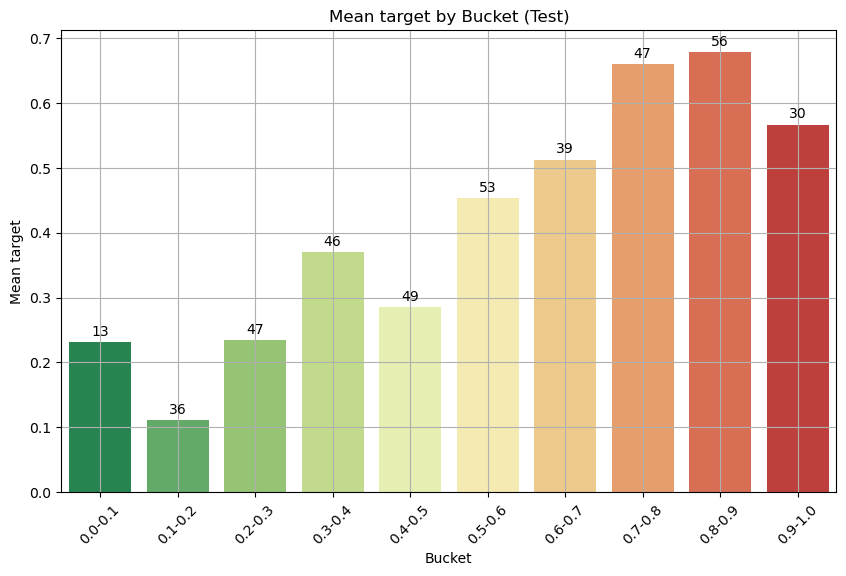

In [97]:
# Calculate decile statistics
decile_stats = df[df['sample'] == 'test'].groupby('decile', observed=False).agg(
    mean_target=(TARGET, 'mean'),
    count=(TARGET, 'size')
).reset_index()

# Clean the data to avoid NaN or infinite values
decile_stats_cleaned = decile_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=decile_stats_cleaned, x='decile', y='mean_target', palette="RdYlGn_r")

# Add the count of objects above each bar
for index, row in decile_stats_cleaned.iterrows():
    plt.text(index, row['mean_target'] + 0.01, f"{int(row['count'])}",
             color='black', ha="center")

# Customize plot appearance
plt.title(f'Mean {TARGET} by Bucket (Test)')
plt.xlabel(f'Bucket')
plt.ylabel(f'Mean {TARGET}')
plt.xticks(rotation=45)
plt.grid()

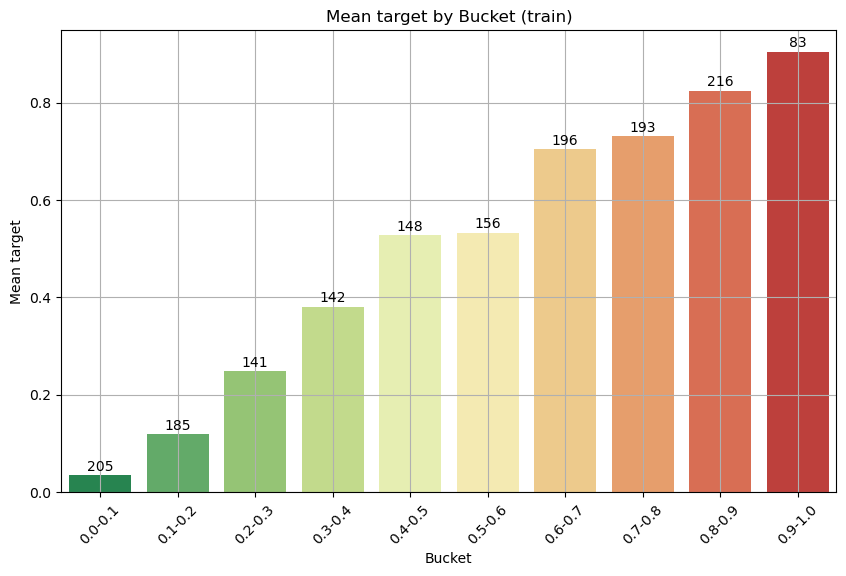

In [98]:
decile_stats = df[df['sample'] == 'train'].groupby('decile', observed=False).agg(
    mean_target=(TARGET, 'mean'), 
    count=(TARGET, 'size')
).reset_index()

# Clean the data to avoid NaN or infinite values
decile_stats_cleaned = decile_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=decile_stats_cleaned, x='decile', y='mean_target', palette="RdYlGn_r")

# Add the count of objects above each bar
for index, row in decile_stats_cleaned.iterrows():
    plt.text(index, row['mean_target'] + 0.01, f"{int(row['count'])}", 
             color='black', ha="center")

# Customize plot appearance
plt.title(f'Mean {TARGET} by Bucket (train)')
plt.xlabel(f'Bucket')
plt.ylabel(f'Mean {TARGET}')
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Kolmogorov-Smirnov

In [99]:
def plot_ks_curve(target, prediction):
    """
    Plots a normalized Kolmogorov-Smirnov (KS) curve for a classification model,
    highlighting the point where the KS statistic reaches its maximum.

    Args:
        target: A numpy array of true labels (0 or 1).
        prediction: A numpy array of predicted probabilities (between 0 and 1).
        threshold: The probability threshold to highlight on the plot.

    Returns:
        None
    """

    # Sort data by predicted probability
    sorted_idx = np.argsort(prediction)  # Sort in ascending order
    sorted_target = target[sorted_idx]
    sorted_prediction = prediction[sorted_idx]

    # Calculate cumulative distribution functions (CDFs) for positive and negative classes
    cum_pos = np.cumsum(sorted_target) / np.sum(sorted_target)
    cum_neg = np.cumsum(1 - sorted_target) / np.sum(1 - sorted_target)

    # Calculate the KS statistic (maximum difference between CDFs)
    ks_stat = np.max(np.abs(cum_pos - cum_neg))
    max_ks_idx = np.argmax(np.abs(cum_pos - cum_neg))
    max_ks_prob = sorted_prediction[max_ks_idx]

    # Plot the KS curve
    plt.plot(sorted_prediction, cum_pos, label='Positive Class')
    plt.plot(sorted_prediction, cum_neg, label='Negative Class')
    plt.axvline(x=max_ks_prob, color='g', linestyle='--', label=f'Max KS: {max_ks_prob:.2f}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Cumulative Probability')
    plt.title('KS Curve (KS Statistic: {:.3f})'.format(ks_stat))
    plt.legend()
    plt.grid(True)
    plt.show()

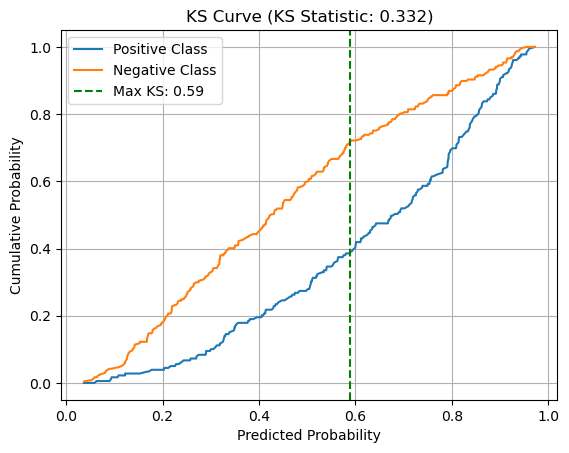

In [100]:
plot_ks_curve(df[df['sample'] == 'test'][TARGET].values, 
              df[df['sample'] == 'test']['y_pred'].values)

In [101]:
bin_edges = np.linspace(0, 1, 11)  # 10 equal-length intervals from 0 to 1
decile_labels = [f"{round(left, 2)}-{round(right, 2)}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]
df['decile'] = pd.cut(df['y_pred'], bins=bin_edges, labels=decile_labels, include_lowest=True)

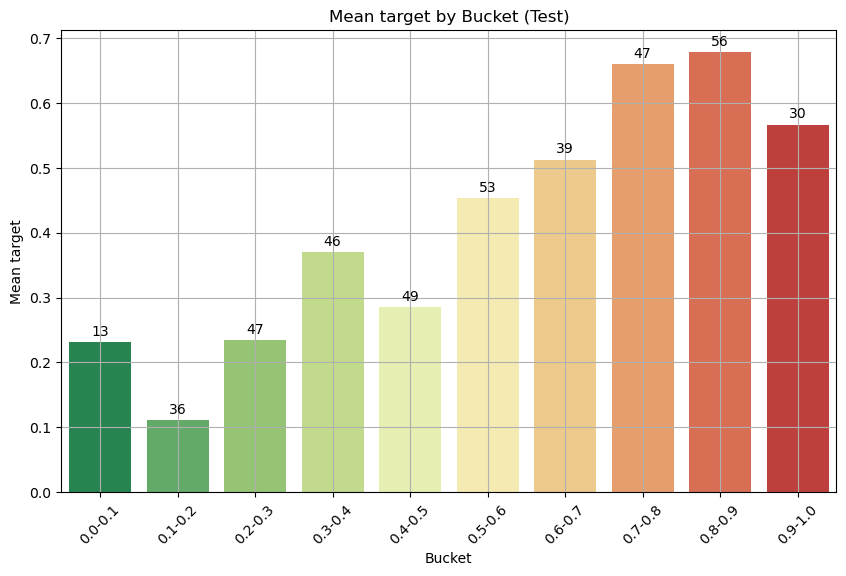

In [102]:
# Calculate decile statistics
decile_stats = df[df['sample'] == 'test'].groupby('decile', observed=False).agg(
    mean_target=(TARGET, 'mean'),
    count=(TARGET, 'size')
).reset_index()

# Clean the data to avoid NaN or infinite values
decile_stats_cleaned = decile_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=decile_stats_cleaned, x='decile', y='mean_target', palette="RdYlGn_r")

# Add the count of objects above each bar
for index, row in decile_stats_cleaned.iterrows():
    plt.text(index, row['mean_target'] + 0.01, f"{int(row['count'])}",
             color='black', ha="center")

# Customize plot appearance
plt.title(f'Mean {TARGET} by Bucket (Test)')
plt.xlabel(f'Bucket')
plt.ylabel(f'Mean {TARGET}')
plt.xticks(rotation=45)
plt.grid()

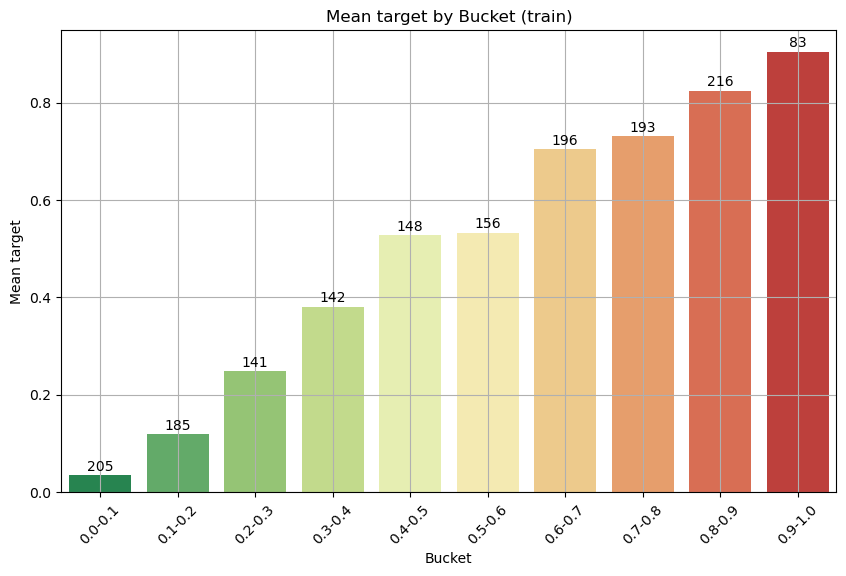

In [103]:
decile_stats = df[df['sample'] == 'train'].groupby('decile', observed=False).agg(
    mean_target=(TARGET, 'mean'), 
    count=(TARGET, 'size')
).reset_index()

# Clean the data to avoid NaN or infinite values
decile_stats_cleaned = decile_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=decile_stats_cleaned, x='decile', y='mean_target', palette="RdYlGn_r")

# Add the count of objects above each bar
for index, row in decile_stats_cleaned.iterrows():
    plt.text(index, row['mean_target'] + 0.01, f"{int(row['count'])}", 
             color='black', ha="center")

# Customize plot appearance
plt.title(f'Mean {TARGET} by Bucket (train)')
plt.xlabel(f'Bucket')
plt.ylabel(f'Mean {TARGET}')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [104]:
def plot_ks_curve(target, prediction):
    """
    Plots a normalized Kolmogorov-Smirnov (KS) curve for a classification model,
    highlighting the point where the KS statistic reaches its maximum.

    Args:
        target: A numpy array of true labels (0 or 1).
        prediction: A numpy array of predicted probabilities (between 0 and 1).
        threshold: The probability threshold to highlight on the plot.

    Returns:
        None
    """

    # Sort data by predicted probability
    sorted_idx = np.argsort(prediction)  # Sort in ascending order
    sorted_target = target[sorted_idx]
    sorted_prediction = prediction[sorted_idx]

    # Calculate cumulative distribution functions (CDFs) for positive and negative classes
    cum_pos = np.cumsum(sorted_target) / np.sum(sorted_target)
    cum_neg = np.cumsum(1 - sorted_target) / np.sum(1 - sorted_target)

    # Calculate the KS statistic (maximum difference between CDFs)
    ks_stat = np.max(np.abs(cum_pos - cum_neg))
    max_ks_idx = np.argmax(np.abs(cum_pos - cum_neg))
    max_ks_prob = sorted_prediction[max_ks_idx]

    # Plot the KS curve
    plt.plot(sorted_prediction, cum_pos, label='Positive Class')
    plt.plot(sorted_prediction, cum_neg, label='Negative Class')
    plt.axvline(x=max_ks_prob, color='g', linestyle='--', label=f'Max KS: {max_ks_prob:.2f}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Cumulative Probability')
    plt.title('KS Curve (KS Statistic: {:.3f})'.format(ks_stat))
    plt.legend()
    plt.grid(True)
    plt.show()

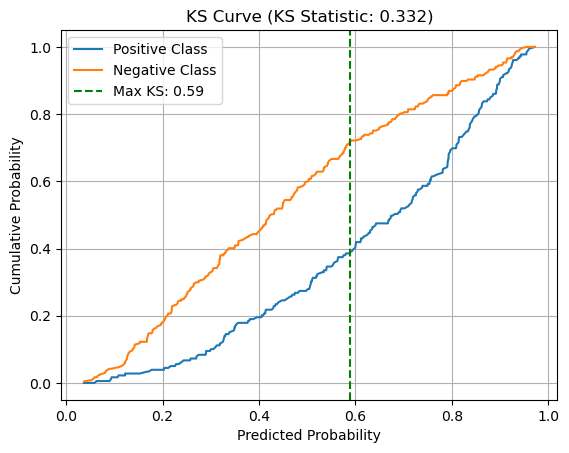

In [105]:
plot_ks_curve(df[df['sample'] == 'test'][TARGET].values, 
              df[df['sample'] == 'test']["y_pred"].values)

In [106]:
# features names
model_features_lst = pipeline_model.steps[-1][1].features_lst

In [107]:
df_features = pipeline_data.transform(
    X=df
)
df_features['sample'] = df['sample']
df_features[TARGET] = df[TARGET]

2025-04-17 03:00:07 - INFO - Simple features - Successfully finished.
2025-04-17 03:00:07 - INFO - Rare categories encoder - transform done.
2025-04-17 03:00:07 - INFO - Cat. binning - tranfsorm done.


Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 21600000.0, 122050000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 132410.765625, 447031.140625, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 406265.59375, 879183.34375, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 68.28000259399414, 149976.8828125, 410261.59375, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__d

2025-04-17 03:00:08 - INFO - Num. binning - tranfsorm done.
/home/jovyan/.local/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) cat__customer.employment.businessSector__bin, cat__application.existingCustomer__bin, cat__application.loanType__bin, num__day_from_begin_to_overdue__bin, num__age__bin, num__days_from_begin_to_overdue_pd__bin.
  warnings.warn(
2025-04-17 03:00:08 - INFO - WOE cat encoder - transform done.
2025-04-17 03:00:08 - INFO - Feature elimination - selected features count:   29.
2025-04-17 03:00:08 - INFO - Feature elimination - transform done.


Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, -0.5, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-129.0, 4.5, 17.5, 39.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-82.0, 11.5, 33.5, 77.5, inf]


## Corr matrix

In [108]:
corr_matrix = df_features[df_features['sample'] == 'train'][model_features_lst].corr()

<AxesSubplot:>

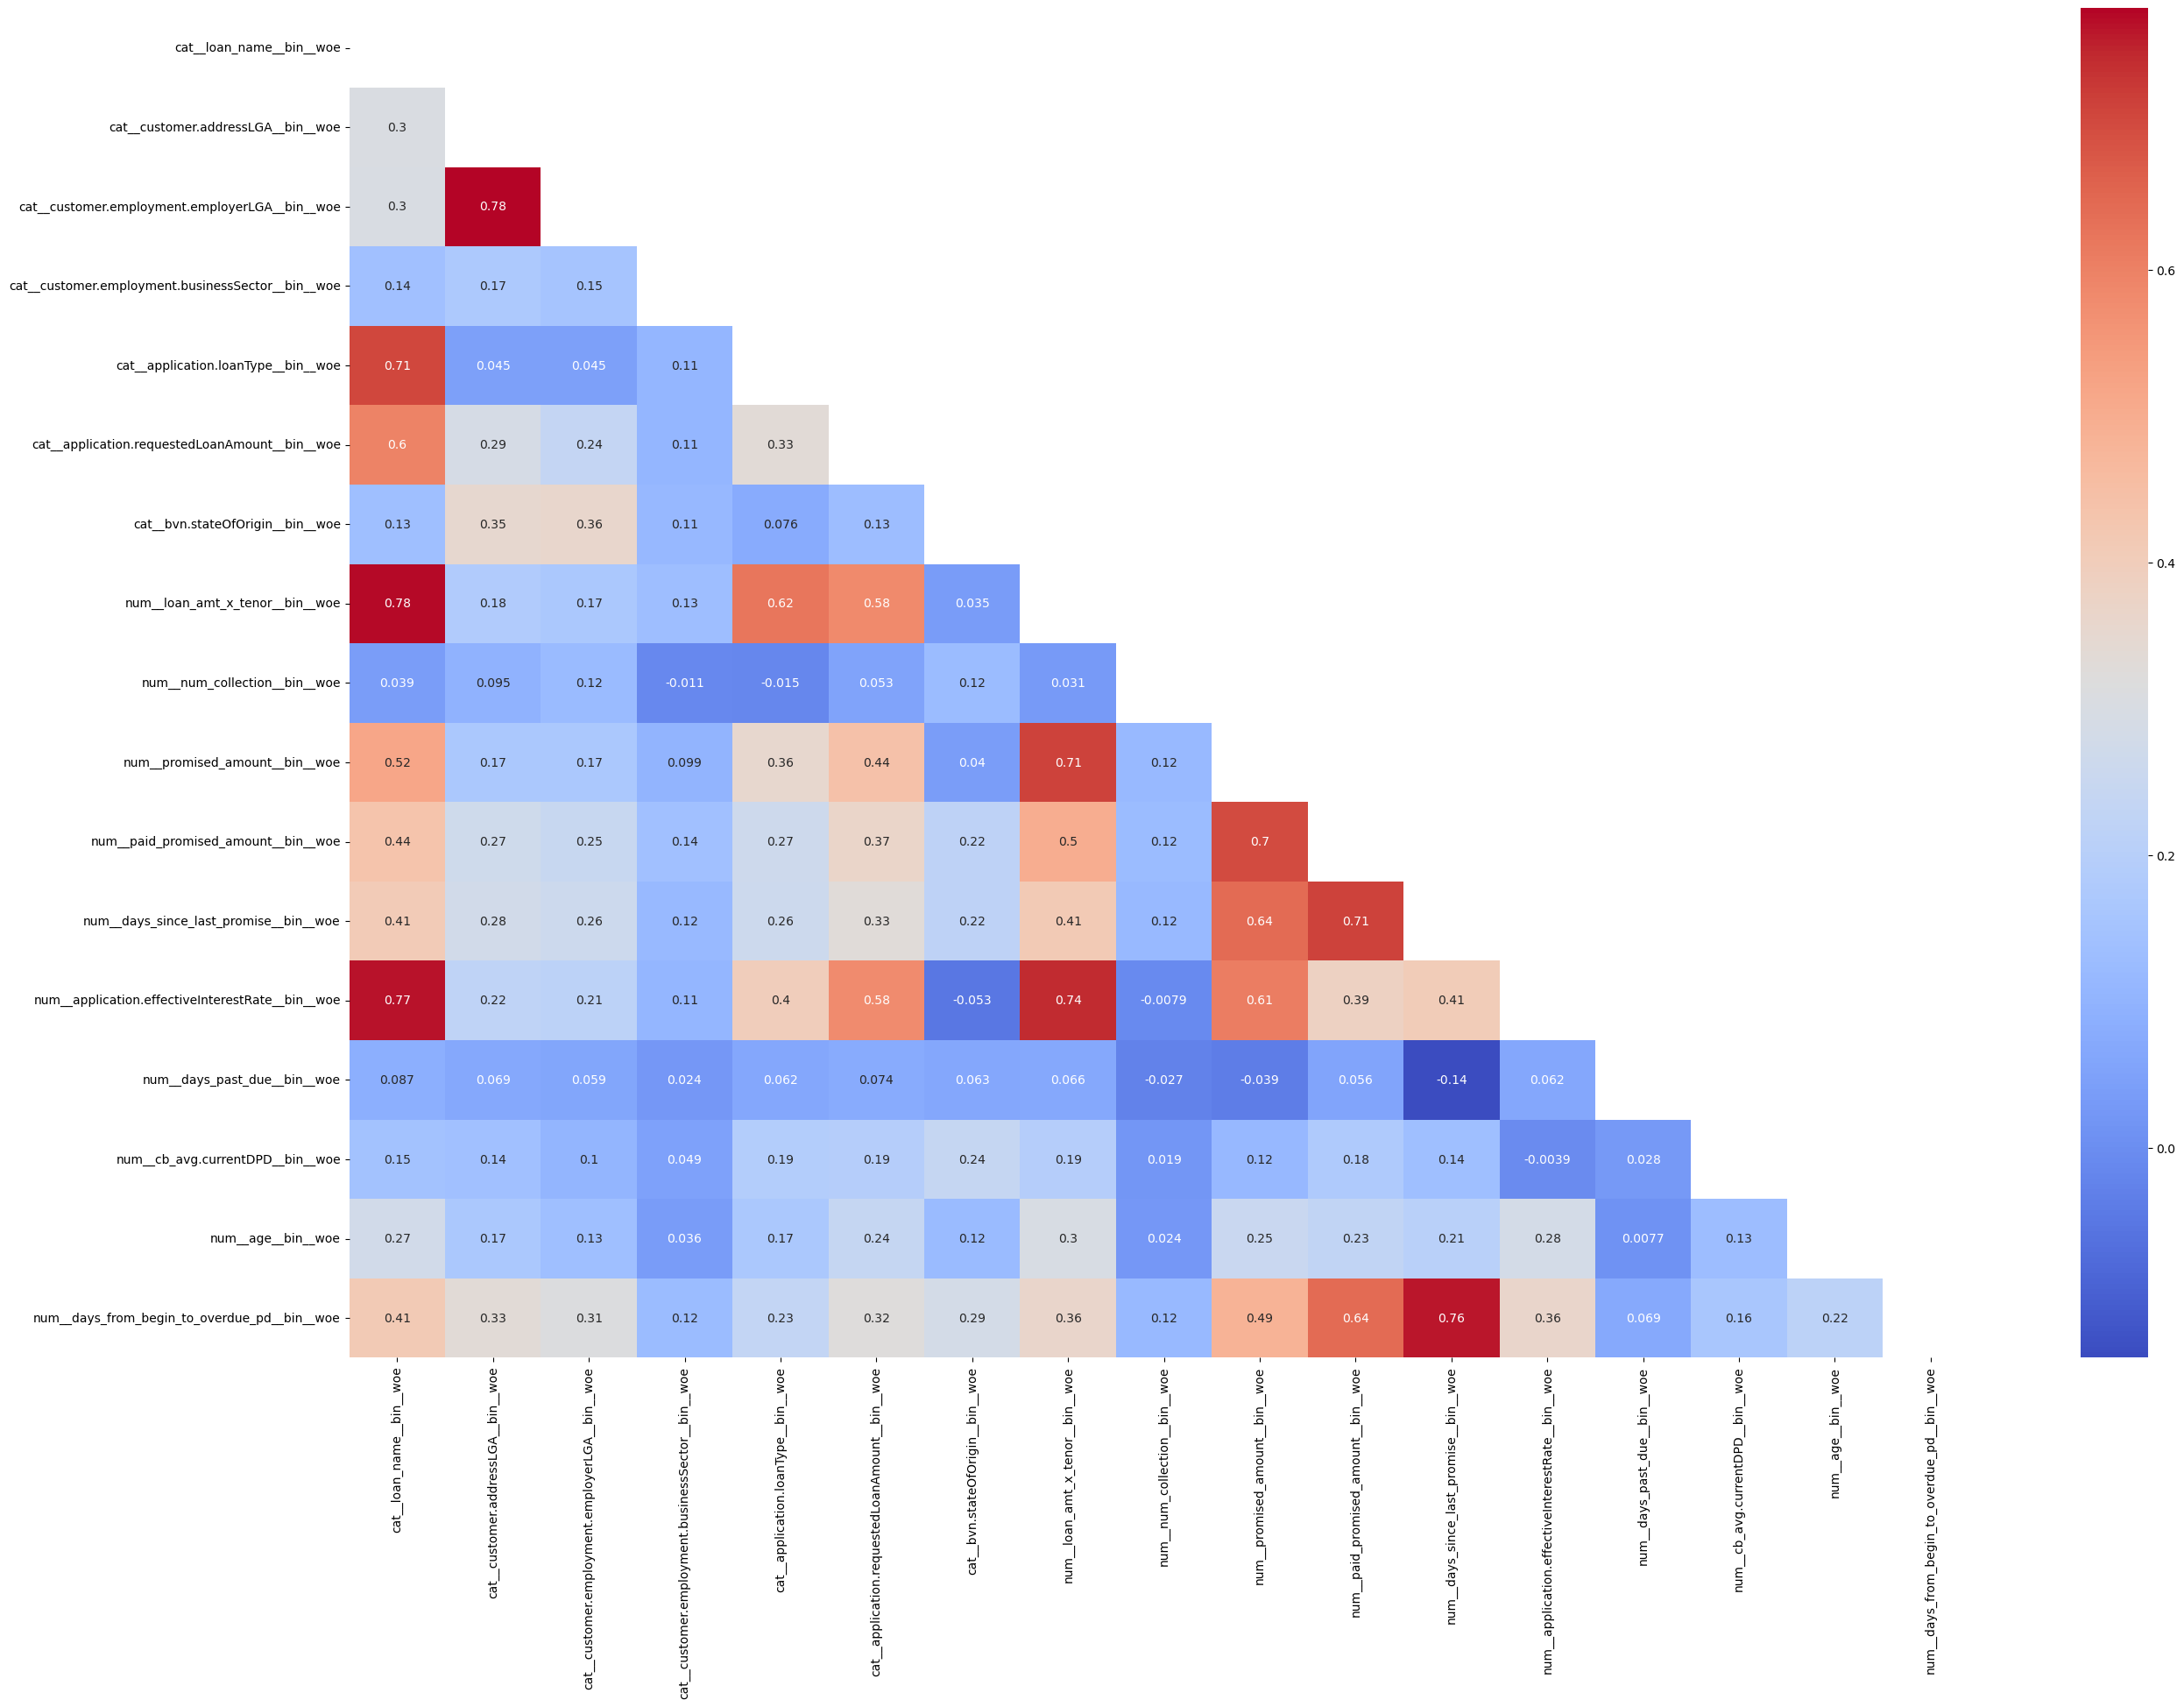

In [109]:
plt.figure(figsize=(30,20))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)

## Merge features 

In [111]:
df.head().T

,0,1,2,3,4
snap_date,2024-02-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00
loan_id,16948487.0000,16950847.0000,16951024.0000,16951210.0000,16951386.0000
loan_balance,0.0000,0.0000,0.0000,0.0000,0.0000
loan_amount,378000.0000,3000000.0000,3000000.0000,730000.0000,1200000.0000
loan_name,Self Employed - Weekly New,Self Employed - Weekly New,Self Employed - Weekly New,Self Employed - Weekly New,Self Employed - Weekly New
loan_tenor,110.0000,110.0000,111.0000,111.0000,107.0000
loan_num,1.0000,1.0000,1.0000,1.0000,1.0000
num_collection,36.0000,47.0000,28.0000,19.0000,27.0000
total_contact_flag,19.0000,6.0000,5.0000,5.0000,7.0000
total_contact_flag_coll,19.0000,6.0000,5.0000,5.0000,7.0000


In [112]:
pipeline_data = Pipeline(steps=pipeline_model.steps[:-1])

df_report_features = pipeline_data.transform(
    X=df 
)

df_report_features = df_report_features.drop(columns=['dt_month', 
                                                      'loan_id'], 
                                             errors='ignore')

df_report = pd.concat([df, df_report_features], axis=1)

significant_features_list = pipeline_model.steps[-1][1].features_lst

pure_features_names = []
for col in significant_features_list:
    parts = col.split('__')
    cleaned = '__'.join(parts[1:-2])  
    pure_features_names.append(cleaned)

bin_features_names = []
for col in significant_features_list:
    parts = col.split('__')
    cleaned = '__'.join(parts[:-1])  
    bin_features_names.append(cleaned)

indicate_features = [
    'dt_month',
    'loan_id',
    'app_date',
    'loan_balance',
    'loan_amount',
    'loan_name',
    'loan_tenor',
    'loan_request_id',
    'target',
    'dt_week',
    'sample',
    'y_pred',
    # ADD COLOMNS YOU NEED EXCEPT FEATURES - THEY WILL BE ADDED IN NEXT STEP
]

report_columns_list = indicate_features + pure_features_names + bin_features_names + significant_features_list

seen = set()
report_columns = []
for col in report_columns_list:
    if col not in seen:
        seen.add(col)
        report_columns.append(col)

df_report_dataset = df_report[report_columns]

2025-04-17 03:01:51 - INFO - Simple features - Successfully finished.
2025-04-17 03:01:51 - INFO - Rare categories encoder - transform done.
2025-04-17 03:01:51 - INFO - Cat. binning - tranfsorm done.


Feature: num__loan_amt_x_tenor, Bins: [2100000.0, 21600000.0, 122050000.0, inf]
Feature: num__loan_num, Bins: [1.0, 1.5, 3.5, inf]
Feature: num__num_collection, Bins: [-1.0, 13.5, 42.5, inf]
Feature: num__non_null_default_reason_count, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__total_payment, Bins: [0.0, 14548.9150390625, 132410.765625, 447031.140625, inf]
Feature: num__total_number_of_payments, Bins: [-1.0, 0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__total_contact_flag_coll, Bins: [-1.0, 1.5, 2.5, 6.5, inf]
Feature: num__days_since_last_payment, Bins: [-1.0, -0.5, 5.5, 15.5, inf]
Feature: num__promised_amount, Bins: [-1.0, 94790.48046875, 406265.59375, 879183.34375, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, 68.28000259399414, 149976.8828125, 410261.59375, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, 0.5, 1.5, inf]
Feature: num__total_number_of_promises, Bins: [-1.0, 1.5, 2.5, 4.5, inf]
Feature: num__d

2025-04-17 03:01:52 - INFO - Num. binning - tranfsorm done.


Feature: num__daily_arrearsprincipal, Bins: [-1.0, inf]
Feature: num__daily_arrearsinterest, Bins: [-1.0, inf]
Feature: num__daily_penaltydue, Bins: [-1.0, inf]
Feature: num__application.renMaxDPD, Bins: [-36.0, inf]
Feature: num__salary_median, Bins: [0.0, inf]
Feature: num__cb_avg.outstandingloan, Bins: [-608497.74, 4900.764892578125, 516846.71875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.currentDPD, Bins: [-1.0, -0.5, inf]
Feature: num__age, Bins: [22.0, 29.5, 36.5, 44.5, inf]
Feature: num__experience, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [-1.0, -0.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [-1.0, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [-1.0, -0.5, inf]
Feature: num__days_from_begin_to_overdue_pd, Bins: [-129.0, 4.5, 17.5, 39.5, inf]
Feature: num__days_until_due_date_pd, Bins: [-82.0, 11.5, 33.5, 77.5, inf]


/home/jovyan/.local/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) cat__customer.employment.businessSector__bin, cat__application.existingCustomer__bin, cat__application.loanType__bin, num__day_from_begin_to_overdue__bin, num__age__bin, num__days_from_begin_to_overdue_pd__bin.
  warnings.warn(
2025-04-17 03:01:52 - INFO - WOE cat encoder - transform done.
2025-04-17 03:01:52 - INFO - Feature elimination - selected features count:   29.
2025-04-17 03:01:52 - INFO - Feature elimination - transform done.


In [113]:
df_report_dataset['model_name'] = 'collection_SEL_BETA_30_60'
df_report_dataset['dataset_table_name'] = 'dataset_collection_SEL_BETA_30_60'

/tmp/ipykernel_3014380/1005765149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report_datatape['model_name'] = 'collection_SEL_BETA_30_60'
/tmp/ipykernel_3014380/1005765149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report_datatape['datatape_table_name'] = 'datatape_collection_SEL_BETA_30_60'


In [114]:
df_report_dataset.shape

(2081, 65)

In [115]:
df_report_dataset.head()

,dt_month,loan_id,snap_date,loan_balance,loan_amount,loan_name,loan_tenor,days_past_due,overdue_bucket,loan_request_id,target,dt_week,sample,y_pred,customer.addressLGA,customer.employment.employerLGA,customer.employment.businessSector,application.loanType,application.requestedLoanAmount,bvn.stateOfOrigin,loan_amt_x_tenor,num_collection,promised_amount,paid_promised_amount,days_since_last_promise,application.effectiveInterestRate,cb_avg.currentDPD,age,days_from_begin_to_overdue_pd,cat__loan_name__bin,cat__customer.addressLGA__bin,cat__customer.employment.employerLGA__bin,cat__customer.employment.businessSector__bin,cat__application.loanType__bin,cat__application.requestedLoanAmount__bin,cat__bvn.stateOfOrigin__bin,num__loan_amt_x_tenor__bin,num__num_collection__bin,num__promised_amount__bin,num__paid_promised_amount__bin,num__days_since_last_promise__bin,num__application.effectiveInterestRate__bin,num__days_past_due__bin,num__cb_avg.currentDPD__bin,num__age__bin,num__days_from_begin_to_overdue_pd__bin,cat__loan_name__bin__woe,cat__customer.addressLGA__bin__woe,cat__customer.employment.employerLGA__bin__woe,cat__customer.employment.businessSector__bin__woe,cat__application.loanType__bin__woe,cat__application.requestedLoanAmount__bin__woe,cat__bvn.stateOfOrigin__bin__woe,num__loan_amt_x_tenor__bin__woe,num__num_collection__bin__woe,num__promised_amount__bin__woe,num__paid_promised_amount__bin__woe,num__days_since_last_promise__bin__woe,num__application.effectiveInterestRate__bin__woe,num__days_past_due__bin__woe,num__cb_avg.currentDPD__bin__woe,num__age__bin__woe,num__days_from_begin_to_overdue_pd__bin__woe,model_name,datatape_table_name
0,2024-02-01,16948487.0000,2024-02-01,0.0000,378000.0000,Self Employed - Weekly New,110.0000,45.0000,30-60,1232730.0000,1,2024-01-29,train,0.6792,Ikeja,Ikeja,Consumer Goods,New,269728.4375,Ogun State,41580000.0000,36.0000,702663.1600,141045.7100,143.0000,15.1900,0.0000,33.0000,147.0000,C,B,B,B,A,C,C,"[21600000.0, 122050000.0)","[14.0, 42.0)","[406266.0, 879183.0)","[68.0, 149977.0)","[50.0, inf)","[13.0, inf)","[44.0, 52.0)","[-0.0, inf)","[30.0, 36.0)","[40.0, inf)",0.2583,-0.0596,-0.0617,-0.0603,-0.2537,0.0422,0.2049,-0.2449,0.0315,0.4196,0.0391,0.9734,0.1121,0.0550,0.1652,-0.1375,0.8343,collection_SEL_BETA_30_60,datatape_collection_SEL_BETA_30_60
1,2024-01-01,16950847.0000,2024-01-01,0.0000,3000000.0000,Self Employed - Weekly New,110.0000,45.0000,30-60,1372833.0000,1,2024-01-01,train,0.8080,Oshodi-Isolo,Ikeja,Consumer Goods,New,5000000.0000,Imo State,330000000.0000,47.0000,2168353.1600,1108496.2000,76.0000,10.4400,0.0000,29.0000,72.0000,C,D,B,B,A,D,C,"[122050000.0, inf)","[42.0, inf)","[879183.0, inf)","[410262.0, inf)","[50.0, inf)","[4.0, 13.0)","[44.0, 52.0)","[-0.0, inf)","[22.0, 30.0)","[40.0, inf)",0.2583,0.5836,-0.0617,-0.0603,-0.2537,1.1467,0.2049,0.7881,0.1908,1.0756,0.9673,0.9734,0.6238,0.0550,0.1652,-0.5135,0.8343,collection_SEL_BETA_30_60,datatape_collection_SEL_BETA_30_60
2,2024-01-01,16951024.0000,2024-01-01,0.0000,3000000.0000,Self Employed - Weekly New,111.0000,35.0000,30-60,1386532.0000,0,2024-01-01,train,0.7930,Ojo,Ojo,Services,New,5000000.0000,Anambra State,333000000.0000,28.0000,972479.0600,709572.1400,17.0000,10.4400,0.0000,36.0000,80.0000,C,C,D,D,A,D,D,"[122050000.0, inf)","[14.0, 42.0)","[879183.0, inf)","[410262.0, inf)","[12.0, 28.0)","[4.0, 13.0)","[31.0, 38.0)","[-0.0, inf)","[30.0, 36.0)","[40.0, inf)",0.2583,0.2704,0.5876,0.3695,-0.2537,1.1467,0.5878,0.7881,0.0315,1.0756,0.9673,-0.6026,0.6238,0.2361,0.1652,-0.1375,0.8343,collection_SEL_BETA_30_60,datatape_collection_SEL_BETA_30_60
3,2024-01-01,16951210.0000,2024-01-01,0.0000,730000.0000,Self Employed - Weekly New,111.0000,41.0000,30-60,1399933.0000,1,2024-01-01,train,0.6671,Ikorodu,Ikorodu,Services,New,3089288.2500,Lagos State,81030000.0000,19.0000,460270.5400,158713.9800,37.0000,10.4400,nan,47.0000,73.0000,C,D,D,D,A,C,C,"[21600000.0, 122050000.0)","[14.0, 42.0)","[406266.0, 879183.0)","[149977.0, 410262.0)","[28.0

In [131]:
# Remove trailing zeros after the decimal for all relevant columns
float_columns = [
    'loan_balance', 'loan_amount', 'y_pred',  
    "loan_id", "loan_tenor", "days_past_due", "loan_request_id",
    
    'loan_amt_x_tenor', 'promised_amount', 
    'num_collection',  'days_since_last_promise', 
    'days_from_begin_to_overdue_pd',
    "cb_avg.currentDPD", 	"age"
]

for column in float_columns:
    df_report_dataset[column] = df_report_dataset[column].apply(
        lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else
                  f"{x:.10f}".rstrip('0').rstrip('.') if isinstance(x, float) else x
    )

/tmp/ipykernel_3014380/1587546173.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report_datatape[column] = df_report_datatape[column].apply(


## Feature summary 

In [132]:
model_coeff_df = pipeline_model.steps[6][1].estimator.params.to_frame(name='Coeff')
model_coeff_df = model_coeff_df.rename_axis("Feature").reset_index()
model_coeff_df.columns = ["Feature", "Coeff"]

In [133]:
model_coeff_df

,Feature,Coeff
0,const,-0.1046
1,cat__loan_name__bin__woe,-0.2443
2,cat__customer.addressLGA__bin__woe,0.1842
3,cat__customer.employment.employerLGA__bin__woe,0.3158
4,cat__customer.employment.businessSector__bin__woe,0.5854
5,cat__application.loanType__bin__woe,0.2646
6,cat__application.requestedLoanAmount__bin__woe,0.7189
7,cat__bvn.stateOfOrigin__bin__woe,0.5182
8,num__loan_amt_x_tenor__bin__woe,0.3179
9,num__num_collection__bin__woe,0.3503


In [134]:
pearson_corr_df = df_report[model_features_lst + [TARGET]].corr()[[TARGET]].rename(columns={TARGET: 'Importance indicator (Pearson corr with target)'})
pearson_corr_df = pearson_corr_df.rename_axis("Feature").reset_index()
pearson_corr_df.columns = ["Feature", "Importance indicator"]

In [135]:
pearson_corr_df

,Feature,Importance indicator
0,cat__loan_name__bin__woe,0.2841
1,cat__customer.addressLGA__bin__woe,0.2455
2,cat__customer.employment.employerLGA__bin__woe,0.2326
3,cat__customer.employment.businessSector__bin__woe,0.1197
4,cat__application.loanType__bin__woe,0.1905
5,cat__application.requestedLoanAmount__bin__woe,0.3163
6,cat__bvn.stateOfOrigin__bin__woe,0.2284
7,num__loan_amt_x_tenor__bin__woe,0.2881
8,num__num_collection__bin__woe,0.1409
9,num__promised_amount__bin__woe,0.3279


In [136]:
iv_train = calculate_information_values(df_report[df_report['sample'] == 'train'], 
                                        significant_features_list, 
                                        TARGET)
iv_train.rename(columns={"IV": "train IV"}, inplace=True)

iv_test = calculate_information_values(df_report[df_report['sample'] == 'test'], 
                                       significant_features_list, 
                                       TARGET)
iv_test.rename(columns={"IV": "test IV"}, inplace=True)

In [137]:
iv = pd.merge(iv_train, iv_test, on="Feature", how="inner")
coeff_iv = pd.merge(model_coeff_df, iv, on="Feature", how="outer")
final = pd.merge(coeff_iv, pearson_corr_df, on="Feature", how="outer")

final.sort_values(by="Importance indicator", ascending=False, inplace=True)
final = final[~final['Feature'].isin(['const', 'target'])]

final

,Feature,Coeff,train IV,test IV,Importance indicator
17,num__days_from_begin_to_overdue_pd__bin__woe,0.6783,0.9402,0.6267,0.4330
12,num__days_since_last_promise__bin__woe,0.2603,0.6279,0.4384,0.3723
11,num__paid_promised_amount__bin__woe,-0.2178,0.5000,0.3969,0.3367
10,num__promised_amount__bin__woe,0.3367,0.4744,0.4414,0.3279
6,cat__application.requestedLoanAmount__bin__woe,0.7189,0.5775,0.2444,0.3163
8,num__loan_amt_x_tenor__bin__woe,0.3179,0.3863,0.2997,0.2881
1,cat__loan_name__bin__woe,-0.2443,0.3811,0.3013,0.2841
2,cat__customer.addressLGA__bin__woe,0.1842,0.3208,0.1283,0.2455
13,num__application.effectiveInterestRate__bin__woe,-0.5823,0.2454,0.1945,0.2335
3,cat__customer.employment.employerLGA__bin__woe,0.3158,0.3026,0.0627,0.2326


In [138]:
model_name='collection_SEL_BETA_30_60'
model_version=1

feature_summary = pd.DataFrame({
    "model_name": model_name,                           # character varying(50)
    "model_version": model_version,                     # integer
    "data_source": np.nan,                              # character varying(100)
    "feature": final["Feature"].astype(str),            # character varying(50)
    "coef_logreg": final["Coeff"].round(4),             # numeric(10,4)
    "train_iv": final["train IV"].round(4),             # numeric(10,4)
    "test_iv": final["test IV"].round(4),               # numeric(10,4)
    "psi": np.nan,                                      # Placeholder: numeric(10,4)
    "tolerance": np.nan,                                # Placeholder: numeric(10,4)
    "importance": final["Importance indicator"],
    "standalone_gini": np.nan                           # Placeholder: numeric(10,4)
})

In [139]:
feature_summary

,model_name,model_version,data_source,feature,coef_logreg,train_iv,test_iv,psi,tolerance,importance,standalone_gini
17,collection_SEL_BETA_30_60,1,nan,num__days_from_begin_to_overdue_pd__bin__woe,0.6783,0.9402,0.6267,nan,nan,0.4330,nan
12,collection_SEL_BETA_30_60,1,nan,num__days_since_last_promise__bin__woe,0.2603,0.6279,0.4384,nan,nan,0.3723,nan
11,collection_SEL_BETA_30_60,1,nan,num__paid_promised_amount__bin__woe,-0.2178,0.5000,0.3969,nan,nan,0.3367,nan
10,collection_SEL_BETA_30_60,1,nan,num__promised_amount__bin__woe,0.3367,0.4744,0.4414,nan,nan,0.3279,nan
6,collection_SEL_BETA_30_60,1,nan,cat__application.requestedLoanAmount__bin__woe,0.7189,0.5775,0.2444,nan,nan,0.3163,nan
8,collection_SEL_BETA_30_60,1,nan,num__loan_amt_x_tenor__bin__woe,0.3179,0.3863,0.2997,nan,nan,0.2881,nan
1,collection_SEL_BETA_30_60,1,nan,cat__loan_name__bin__woe,-0.2443,0.3811,0.3013,nan,nan,0.2841,nan
2,collection_SEL_BETA_30_60,1,nan,cat__customer.addressLGA__bin__woe,0.1842,0.3208,0.1283,nan,nan,0.2455,nan
13,collection_SEL_BETA_30_60,1,nan,num__application.effectiveInterestRate__bin__woe,-0.5823,0.2454,0.1945,nan,nan,0.2335,nan
3,collection_SEL_BETA_30_60,1,nan,cat__customer.employment.employerLGA__bin__woe,0.3158,0.3026,0.0627,nan,nan,0.2326,nan


## Export to RedShift

In [140]:
# (removed) proprietary paths were redacted for public demo


In [141]:
feature_summary.to_csv(feature_data_path, index=False, sep='|')

df_report_dataset.to_csv(dataset_data_path, index=False, sep='|')

In [142]:
df_report_dataset.head()

,dt_month,loan_id,snap_date,loan_balance,loan_amount,loan_name,loan_tenor,days_past_due,overdue_bucket,loan_request_id,target,dt_week,sample,y_pred,customer.addressLGA,customer.employment.employerLGA,customer.employment.businessSector,application.loanType,application.requestedLoanAmount,bvn.stateOfOrigin,loan_amt_x_tenor,num_collection,promised_amount,paid_promised_amount,days_since_last_promise,application.effectiveInterestRate,cb_avg.currentDPD,age,days_from_begin_to_overdue_pd,cat__loan_name__bin,cat__customer.addressLGA__bin,cat__customer.employment.employerLGA__bin,cat__customer.employment.businessSector__bin,cat__application.loanType__bin,cat__application.requestedLoanAmount__bin,cat__bvn.stateOfOrigin__bin,num__loan_amt_x_tenor__bin,num__num_collection__bin,num__promised_amount__bin,num__paid_promised_amount__bin,num__days_since_last_promise__bin,num__application.effectiveInterestRate__bin,num__days_past_due__bin,num__cb_avg.currentDPD__bin,num__age__bin,num__days_from_begin_to_overdue_pd__bin,cat__loan_name__bin__woe,cat__customer.addressLGA__bin__woe,cat__customer.employment.employerLGA__bin__woe,cat__customer.employment.businessSector__bin__woe,cat__application.loanType__bin__woe,cat__application.requestedLoanAmount__bin__woe,cat__bvn.stateOfOrigin__bin__woe,num__loan_amt_x_tenor__bin__woe,num__num_collection__bin__woe,num__promised_amount__bin__woe,num__paid_promised_amount__bin__woe,num__days_since_last_promise__bin__woe,num__application.effectiveInterestRate__bin__woe,num__days_past_due__bin__woe,num__cb_avg.currentDPD__bin__woe,num__age__bin__woe,num__days_from_begin_to_overdue_pd__bin__woe,model_name,datatape_table_name
0,2024-02-01,16948487,2024-02-01,0,378000,Self Employed - Weekly New,110,45,30-60,1232730,1,2024-01-29,train,0.6792407618,Ikeja,Ikeja,Consumer Goods,New,269728.4375,Ogun State,41580000,36,702663.16,141045.7100,143,15.1900,0,33,147,C,B,B,B,A,C,C,"[21600000.0, 122050000.0)","[14.0, 42.0)","[406266.0, 879183.0)","[68.0, 149977.0)","[50.0, inf)","[13.0, inf)","[44.0, 52.0)","[-0.0, inf)","[30.0, 36.0)","[40.0, inf)",0.2583,-0.0596,-0.0617,-0.0603,-0.2537,0.0422,0.2049,-0.2449,0.0315,0.4196,0.0391,0.9734,0.1121,0.0550,0.1652,-0.1375,0.8343,collection_SEL_BETA_30_60,datatape_collection_SEL_BETA_30_60
1,2024-01-01,16950847,2024-01-01,0,3000000,Self Employed - Weekly New,110,45,30-60,1372833,1,2024-01-01,train,0.80798362,Oshodi-Isolo,Ikeja,Consumer Goods,New,5000000,Imo State,330000000,47,2168353.1600000001,1108496.2000,76,10.4400,0,29,72,C,D,B,B,A,D,C,"[122050000.0, inf)","[42.0, inf)","[879183.0, inf)","[410262.0, inf)","[50.0, inf)","[4.0, 13.0)","[44.0, 52.0)","[-0.0, inf)","[22.0, 30.0)","[40.0, inf)",0.2583,0.5836,-0.0617,-0.0603,-0.2537,1.1467,0.2049,0.7881,0.1908,1.0756,0.9673,0.9734,0.6238,0.0550,0.1652,-0.5135,0.8343,collection_SEL_BETA_30_60,datatape_collection_SEL_BETA_30_60
2,2024-01-01,16951024,2024-01-01,0,3000000,Self Employed - Weekly New,111,35,30-60,1386532,0,2024-01-01,train,0.793047555,Ojo,Ojo,Services,New,5000000,Anambra State,333000000,28,972479.0600000001,709572.1400,17,10.4400,0,36,80,C,C,D,D,A,D,D,"[122050000.0, inf)","[14.0, 42.0)","[879183.0, inf)","[410262.0, inf)","[12.0, 28.0)","[4.0, 13.0)","[31.0, 38.0)","[-0.0, inf)","[30.0, 36.0)","[40.0, inf)",0.2583,0.2704,0.5876,0.3695,-0.2537,1.1467,0.5878,0.7881,0.0315,1.0756,0.9673,-0.6026,0.6238,0.2361,0.1652,-0.1375,0.8343,collection_SEL_BETA_30_60,datatape_collection_SEL_BETA_30_60
3,2024-01-01,16951210,2024-01-01,0,730000,Self Employed - Weekly New,111,41,30-60,1399933,1,2024-01-01,train,0.667144561,Ikorodu,Ikorodu,Services,New,3089288.25,Lagos State,81030000,19,460270.54,158713.9800,37,10.4400,nan,47,73,C,D,D,D,A,C,C,"[21600000.0, 122050000.0)","[14.0, 42.0)","[406266.0, 879183.0)","[149977.0, 410262.0)","[28.0, 50.0)","[4.0, 13.0)","[38.0, 44.0)","[-1.0, -0.0)","[44.0, inf)","[40.0, inf)",0.2583,0.5836,0.5876,0.3695,-0.2537,0.0422,0.2049,-0.2449,0.0315,0.4196,0.7466,0.3890,0.6238,0.1382,-0.4511,0.4401,0.8343,collection_SEL_B

In [143]:
df_report_dataset.columns 

Index(['dt_month', 'loan_id', 'snap_date', 'loan_balance', 'loan_amount',
       'loan_name', 'loan_tenor', 'days_past_due', 'overdue_bucket',
       'loan_request_id', 'target', 'dt_week', 'sample', 'y_pred',
       'customer.addressLGA', 'customer.employment.employerLGA',
       'customer.employment.businessSector', 'application.loanType',
       'application.requestedLoanAmount', 'bvn.stateOfOrigin',
       'loan_amt_x_tenor', 'num_collection', 'promised_amount',
       'paid_promised_amount', 'days_since_last_promise',
       'application.effectiveInterestRate', 'cb_avg.currentDPD', 'age',
       'days_from_begin_to_overdue_pd', 'cat__loan_name__bin',
       'cat__customer.addressLGA__bin',
       'cat__customer.employment.employerLGA__bin',
       'cat__customer.employment.businessSector__bin',
       'cat__application.loanType__bin',
       'cat__application.requestedLoanAmount__bin',
       'cat__bvn.stateOfOrigin__bin', 'num__loan_amt_x_tenor__bin',
       'num__num_collection_

## Payment amount model (regression on payers only)

This section reuses the **same engineered feature space** from the pipeline and trains a regression model only on records with `target=1`.

We then compute `expected_amount = P(pay=1) * E(amount | pay=1)`.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reuse the feature engineering pipeline (all steps except the final classifier)
pipeline_data = Pipeline(steps=pipeline_model.steps[:-1])

df_features = pipeline_data.transform(X=df_sample)

# The transformers may return a dataframe including target; ensure we keep only feature columns
df_features = df_features.drop(columns=[TARGET], errors='ignore')

# Align indices
df_paid = df_sample[df_sample[TARGET] == 1].copy()
df_paid_features = df_features.loc[df_paid.index].copy()

y_amt = df_paid["amount_of_payment"]
X_amt = df_paid_features

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_amt, y_amt, test_size=0.25, random_state=42)

reg_model = Ridge(alpha=1.0, random_state=42)
reg_model.fit(X_train_a, y_train_a)

pred_a = np.clip(reg_model.predict(X_test_a), 0, None)

mae = mean_absolute_error(y_test_a, pred_a)
rmse = mean_squared_error(y_test_a, pred_a, squared=False)
r2 = r2_score(y_test_a, pred_a)

print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R2:   {r2:.4f}")


In [ ]:
# Actual vs Predicted (amount) — payers only
plt.figure(figsize=(6,4))
plt.scatter(y_test_a, pred_a, s=10, alpha=0.35)
mx = np.quantile(np.r_[y_test_a, pred_a], 0.98)
plt.plot([0, mx], [0, mx], linestyle="--")
plt.xlim(0, mx)
plt.ylim(0, mx)
plt.title("Payment amount — Actual vs Predicted (payers only)")
plt.xlabel("Actual amount")
plt.ylabel("Predicted amount")
plt.tight_layout()
plt.show()


In [ ]:
# Expected amount for all records (two-stage)
p_pay_all = pipeline_model.predict_proba(df_sample)[:, 1]
amt_if_paid_all = np.clip(reg_model.predict(df_features), 0, None)

df_out = df_sample[["loan_id", "snap_date", "loan_name", "overdue_bucket"]].copy()
df_out["p_pay"] = p_pay_all
df_out["amt_if_paid"] = amt_if_paid_all
df_out["expected_amount"] = df_out["p_pay"] * df_out["amt_if_paid"]

df_out.head()
